In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# card 데이터 로드
card = pd.read_csv("CARD_SPENDING_RESIDENT.txt", sep="\t")

# 외국인의 데이터도 결국 한국에서 사용하는것이기 때문에 한국에서의 구매력으로 환산하여 더하기로함
card_dong = pd.read_excel("card_instruct.xlsx", sheet_name=1, header=1).drop('Unnamed: 0', axis=1)

card = card.merge(card_dong, how='left', left_on = ['GU_CD', 'DONG_CD'], right_on = ['구코드', '행정동코드'])

line = pd.read_excel("card_instruct.xlsx",sheet_name = 2, header=1).drop("Unnamed: 0", axis=1)
line_code = pd.DataFrame(line['업종코드 (32개 분류)'].dropna())
line_code.reset_index(drop=True, inplace = True)

code_list = []
line_list = []

for line in line_code['업종코드 (32개 분류)']:
    code = line[-3:-1]
    name = line[:-4]
    
    code_list.append(code)
    line_list.append(name)
    
line_dic = {
    'MCT_CAT_CD' : code_list,
    'MCT_CAT_NM' : line_list
}

#업종별 테이블 생성
line_table = pd.DataFrame(line_dic)
# 카드 데이터와 맞추기 위해 타입변경
line_table['MCT_CAT_CD'] = line_table['MCT_CAT_CD'].astype("int64")

card = card.merge(line_table, how='left', on = 'MCT_CAT_CD')


card.drop(['GU_CD', 'DONG_CD','MCT_CAT_CD', 'SEX_CD', 'AGE_CD', '구코드', '행정동코드'], axis=1,inplace=True)


card.columns = ['일자', '이용건수', '이용금액','구명','행정동명','업종명']

In [3]:
# cj 물류 파일 로드
os.chdir("./cj")

cj = pd.read_excel('cj_data.xlsx')

# cj 데이터 일자 양식맞추기
cj['DL_YMD'] = cj['DL_YMD'] + 20000000

cj.drop(['DL_GD_LCLS_CD','CTPV_CD', 'CTGG_CD','HDNG_CD'], axis=1, inplace=True)

cj.columns = ['일자', '업종명', '시명', '구명', '행정동명', '물류건수']

In [4]:
# gs 유통파일 로드
gs = pd.read_excel('../gs_retail.xlsx', sheet_name = 5)

gs.columns = ['일자', '시명', '구명', '행정동명', '매출지수', '식사_비중', '간식_비중', '마실거리_비중', '홈&리빙_비중', '헬스&뷰티_비중', '취미&여가활동_비중', '사회활동_비중', '임신/육아_비중']

In [5]:
# sk 유동인구 파일 로드
os.chdir('../sk')
files_sk = os.listdir()

sk = pd.DataFrame()

for file in files_sk[:8]:
    temp = pd.read_csv(file, sep="|")
    
    sk = sk.append(temp)

In [6]:
# 각 일자별 동의 유동인구 합산량을 바탕으로 분석을 진행하기 위해 'sum_flow' 컬럼 생성
# 유동인구를 나타내는 칼럼들
num_columns = ['MAN_FLOW_POP_CNT_0004',
       'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
       'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
       'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
       'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']
sk['sum_flow'] = sk[num_columns].sum(axis=1)

sk.drop(['STD_YM', 'HDONG_CD']+num_columns, axis=1,inplace=True)

sk.columns = ['일자', '행정동명', '유동인원']

In [7]:
# 각 데이터의 행정동 unique() 개수가 달라 추가 조사
print(f"sk 행정동 개수 : {len(sk['행정동명'].unique())}")
print(f"cj 행정동 개수 : {len(cj['행정동명'].unique())}")
print(f"card 행정동 개수 : {len(card['행정동명'].unique())}")
print(f"gs 행정동 개수 : {len(gs['행정동명'].unique())}")

sk 행정동 개수 : 69
cj 행정동 개수 : 69
card 행정동 개수 : 69
gs 행정동 개수 : 60


In [8]:
# 겹치는 주어진 데이터에 겹치는 행정동명이 있는지 확인 
len(cj[['시명', '구명', '행정동명']].drop_duplicates()) #확인결과 없음

69

In [9]:
# cj에는 있고 gs에는 없는 행정동명 색출
empty_dong = list(set(cj['행정동명'].unique()) - set(gs['행정동명'].unique()))

In [10]:
# cj의 시/구/행정동 정보를 추출
dong_info  = cj[['시명', '구명', '행정동명']].drop_duplicates()
dong_info.reset_index(drop=True, inplace=True)

In [11]:
difference_index = dong_info[dong_info['행정동명'].isin(empty_dong)].index.tolist()

# 겹치지 않는 10개동을 제외한 총 59개의 동을 분석 대상으로 선정
dong_info.drop(difference_index, axis=0,inplace=True)
dong_info.reset_index(drop=True, inplace=True)

In [12]:
# 선정된 시, 구, 동을 기준으로 나머지 데이터와 통일
sk = sk.merge(dong_info, how='inner', on='행정동명')
card.drop("구명", axis=1, inplace=True)
card = card.merge(dong_info, how='inner', on='행정동명')
gs.drop(['시명', '구명'], axis=1, inplace=True)
gs = gs.merge(dong_info, how='inner', on='행정동명')
cj.drop(['시명','구명'], axis=1, inplace=True)
cj = cj.merge(dong_info, how = 'inner', on = '행정동명')

In [13]:
# 년, 월, 일, 주차를 추가하기 위한 함수
def datetime_format(df):
    df['일자'] = df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d', errors='raise')
    df['년'] = df['일자'].dt.year
    df['월'] = df['일자'].dt.month
    df['일'] = df['일자'].dt.day
    df['주차'] = df['일자'].dt.weekofyear
    
    return df

In [14]:
data = [sk, card, gs, cj]

# 각 데이터 년/월/일 추가
[datetime_format(x) for x in data]

# 5주차의 데이터는 2019년의 경우 3일, 2020년의 경우 2일이 포함됨.
# 22주차의 데이터는 2019년의 5일, 2020년의 경우 7일 모두 포함됨
# 이에따라 19년 대비 20년의 수치를 비교하기에는 기준이 다르다고 판단하여
# 5주차, 22주차의 데이터는 분석에서 제외

sk = sk[sk['주차'].isin(range(6,22))].reset_index(drop=True)
cj = cj[cj['주차'].isin(range(6,22))].reset_index(drop=True)
card = card[card['주차'].isin(range(6,22))].reset_index(drop=True)
gs = gs[gs['주차'].isin(range(6,22))].reset_index(drop=True)

In [92]:
from sklearn.preprocessing import MinMaxScaler

def get_scaled(df, col = ""):
    scaler = MinMaxScaler()
    scaler.fit(np.array(df[col]).reshape(-1, 1))
    return np.round(scaler.transform(np.array(df[col]).reshape(-1,1)), 2)

In [33]:
# 일자별 전반적인 카드소비 트랜드를 보기위해 데이터 추출
card_MA = card.pivot_table(index=['일자','년','월','일','주차'], values = ['이용건수', '이용금액'], aggfunc='sum').reset_index()

# 19년도와 20년도 데이터 분리
card_MA_2019 = card_MA[card_MA['년'] == 2019]
card_MA_2020 = card_MA[card_MA['년'] == 2020]

# 카드 매출의 숨겨진 추세를 파악하기 위해 이동평균값 확인
card_MA_2019['이동평균_금액'] = card_MA_2019['이용금액'].rolling(window=3, min_periods=1).mean()
card_MA_2020['이동평균_금액'] = card_MA_2020['이용금액'].rolling(window=3, min_periods=1).mean()
card_MA_2019['이동평균_건수'] = card_MA_2019['이용건수'].rolling(window=3, min_periods=1).mean()
card_MA_2020['이동평균_건수'] = card_MA_2020['이용건수'].rolling(window=3, min_periods=1).mean()

card_MA_2019.reset_index(drop=True, inplace=True)
card_MA_2020.reset_index(drop=True, inplace=True)

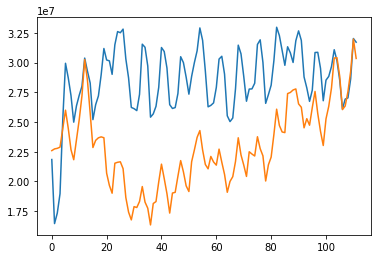

In [34]:
card_MA_2019['이동평균_금액'].plot()
card_MA_2020['이동평균_금액'].plot()

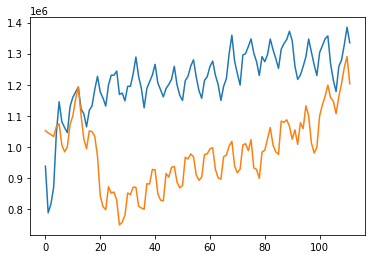

In [35]:
card_MA_2019['이동평균_건수'].plot()
card_MA_2020['이동평균_건수'].plot()

In [37]:
# 주차별 이동평균 값의 평균값 산출
card_MA_2019_week = card_MA_2019.groupby("주차")['이동평균_금액', '이동평균_건수'].mean()
card_MA_2020_week = card_MA_2020.groupby("주차")['이동평균_금액', '이동평균_건수'].mean()

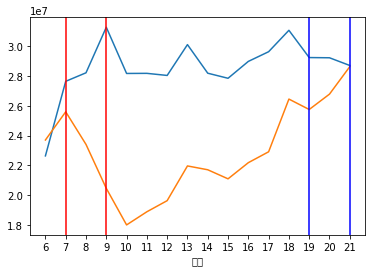

In [38]:
card_MA_2019_week['이동평균_금액'].plot()
card_MA_2020_week['이동평균_금액'].plot()

plt.xticks(range(6,22))
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

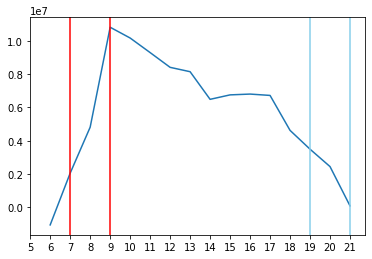

In [39]:
plt.plot(card_MA_2019_week['이동평균_금액'] - card_MA_2020_week['이동평균_금액'])
plt.xticks(range(5,22))
# 매출이 확 줄어드는 시기
# 이후 점점 회복세
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

# 매출이 급증하며 기본 카드매출을 따라잡는 구간
# 새로운 경제의 트랜드를 나타내는 시기가 아닐까 싶음
plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

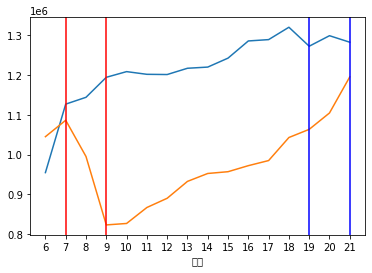

In [40]:
card_MA_2019_week['이동평균_건수'].plot()
card_MA_2020_week['이동평균_건수'].plot()

plt.xticks(range(6,22))
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

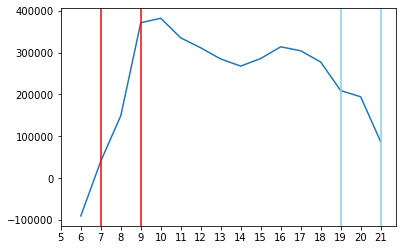

In [41]:
plt.plot(card_MA_2019_week['이동평균_건수'] - card_MA_2020_week['이동평균_건수'])
plt.xticks(range(5,22))
# 매출이 확 줄어드는 시기
# 이후 점점 회복세
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

# 매출이 급증하며 기본 카드매출을 따라잡는 구간
# 새로운 경제의 트랜드를 나타내는 시기가 아닐까 싶음
plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

이를 근거로 카드 매출이 급감한 7-9주차 -> 소비 위축

10주차 부터 점점 소비활동이 정상 범주로 돌아오고 있음

변화의 기울기로 볼때 19-21주차에 소비가 안정되고 기존 카드 매출액을 따라 잡으며
새로운 소비형태를 보여줄 수 있는 시기라고 생각


-> 분석의 기준을 주차로 설정

In [42]:
def get_index_table(df, col_name = ""):
    df_index = df.pivot_table(index=['주차', '시명', '구명', '행정동명', '년'], values=[col_name], aggfunc='sum')
    
    df_index_2019 = df_index.xs(2019,level=4, axis=0).reset_index()
    df_index_2020 = df_index.xs(2020,level=4, axis=0).reset_index()
    
    df_index = df_index_2019.merge(df_index_2020, how='inner', on = ['주차', '시명', '구명', '행정동명'])
    
    return df_index

In [43]:
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

# 유동인구 데이터 파해치기

In [93]:
# 지수 생성을 위한 주차별 테이블을 생성
sk_index = get_index_table(sk, '유동인원')
sk_index.columns = ['주차', '시명', '구명', '행정동명', '유동인원_2019', '유동인원_2020']

In [94]:
sk_index['유동평균_2019'] = sk_index['유동인원_2019'].rolling(window=3, min_periods=1).mean()
sk_index['유동평균_2020'] = sk_index['유동인원_2020'].rolling(window=3, min_periods=1).mean()

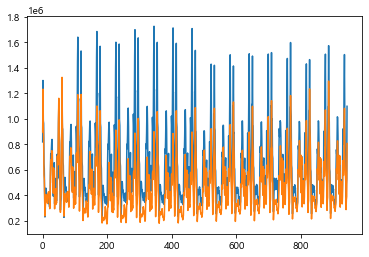

In [95]:
# 유동인구의 추세는 비슷비슷함
sk_index['유동평균_2019'].plot()
sk_index['유동평균_2020'].plot()

--> 2020년도와 2019년도의 유동인구의  경향성은 비슷하다고 보여짐

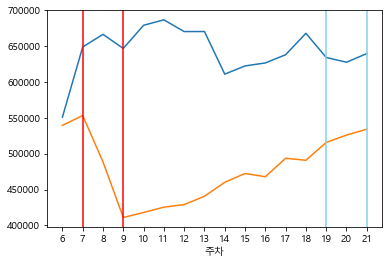

In [96]:
sk_index.groupby('주차')['유동평균_2019'].mean().plot()
sk_index.groupby('주차')['유동평균_2020'].mean().plot()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.xticks(range(6,22))

plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

### 마찬가지로 7-8주차에 감소하는 모습

# 서울/대구 분리

In [97]:
sk_index_seoul = sk_index[sk_index['시명'] == '서울특별시']
sk_index_daegu = sk_index[sk_index['시명'] == '대구광역시']

## 서울의 유동인구 이평부터 보기

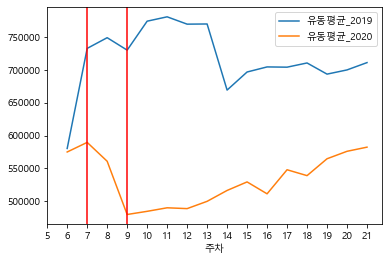

In [98]:
sk_index_seoul.groupby("주차")['유동평균_2019'].mean().plot()
sk_index_seoul.groupby("주차")['유동평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 대구의 유동인구 이평 보기

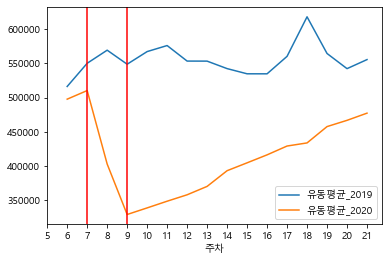

In [99]:
sk_index_daegu.groupby("주차")['유동평균_2019'].mean().plot()
sk_index_daegu.groupby("주차")['유동평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 유동평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 유동 지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [100]:
sk_index['유동지수'] = (sk_index['유동평균_2020'] * 100) / sk_index['유동평균_2019']

## 각 지수들의 척도를 맞춰주기 위해 Min-Max 스케일링 실시

In [101]:
sk_index['유동지수'] = get_scaled(sk_index, '유동지수')

## 평균적인 유동인구 지수

In [104]:
sk_index['유동지수'].mean()

0.41812499999999997

In [105]:
sk_index.groupby("시명")['유동지수'].mean()

시명
대구광역시    0.407616
서울특별시    0.426992
Name: 유동지수, dtype: float64

### 확실히 대구가 더 낮아진 모습

### 전체말고 보고싶은 7-9 주차의 유동인구만을 봐보자

In [106]:
sk_index_sep = sk_index[sk_index['주차'].isin(range(7,10))]
sk_index_sep_seoul = sk_index_sep[sk_index_sep['시명'] == '서울특별시']
sk_index_sep_daegu = sk_index_sep[sk_index_sep['시명'] == '대구광역시']

In [107]:
sk_index_sep['유동지수'].mean()

0.40242937853107325

In [108]:
# 시별로 살펴보기
sk_index_sep.groupby("시명")['유동지수'].mean()

시명
대구광역시    0.400370
서울특별시    0.404167
Name: 유동지수, dtype: float64

### -> 마찬가지로 7-9주차에 대구의 유동인구가 더 많이 감소한 모습

## 서울/대구 구별로 살펴보기

In [109]:
sk_index_sep_seoul['유동지수'].mean()

0.4041666666666666

In [110]:
# 서울의 구별
sk_index_sep_seoul.groupby("구명")['유동지수'].mean()

구명
노원구    0.442037
중구     0.355476
Name: 유동지수, dtype: float64

유동인구량의 감소율의 총 량 : 0.40423698039698724 인데 비해

노원구는 줄긴했으나 총 변동률 대비 별로 안줄어들었고, 중구는 총 변동률보다 많이 줄어든 모습이다.

-> 유동인구의 타격은 중구 > 노원구

In [111]:
sk_index_sep_daegu['유동지수'].mean()

0.40037037037037043

In [112]:
sk_index_sep_daegu.groupby("구명")['유동지수'].mean()

구명
수성구    0.426667
중구     0.325238
Name: 유동지수, dtype: float64

대구의 경우 수성구보다 중구가 유동인구의 타격을 엄청 많이본 모습

## 시각화 함수 - 유동지수

In [113]:
def get_plot_trend(df, x_axis, gu_name, index = "", rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df[index].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index][x_axis].values
    sns.barplot(x = x_axis, y=index, data=df, order=plot_order)
    plt.axhline(df[index].mean())
    df = df.sort_values(by=index, ascending=False)
    df[index] = np.round(df[index],2)
    for idx, score in enumerate(df[index]):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

## 동별로 살펴보자

In [114]:
# 서울 구별로 나눈 데이터
sk_index_sep_seoul_nowon = sk_index_sep_seoul[sk_index_sep_seoul['구명'] == '노원구']
sk_index_sep_seoul_junggu = sk_index_sep_seoul[sk_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
sk_index_sep_daegu_suseong = sk_index_sep_daegu[sk_index_sep_daegu['구명'] == '수성구']
sk_index_sep_daegu_junggu = sk_index_sep_daegu[sk_index_sep_daegu['구명'] == '중구']

In [115]:
sk_index_sep_seoul_nowon['유동지수'].mean()

0.442037037037037

##  서울 - 노원구


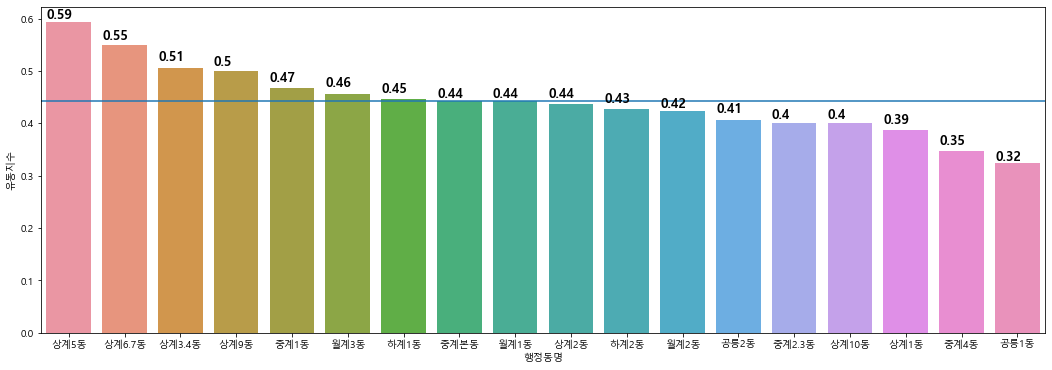

In [116]:
# 서울노원구
nowon_index = sk_index_sep_seoul_nowon.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '유동지수')

## 서울 - 중구

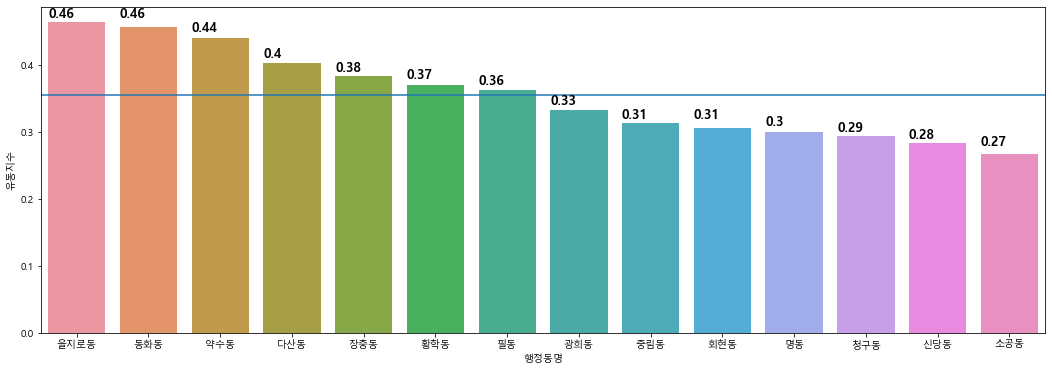

In [117]:
# 서울중구
junggu_index = sk_index_sep_seoul_junggu.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유동지수')

## 대구 - 수성구

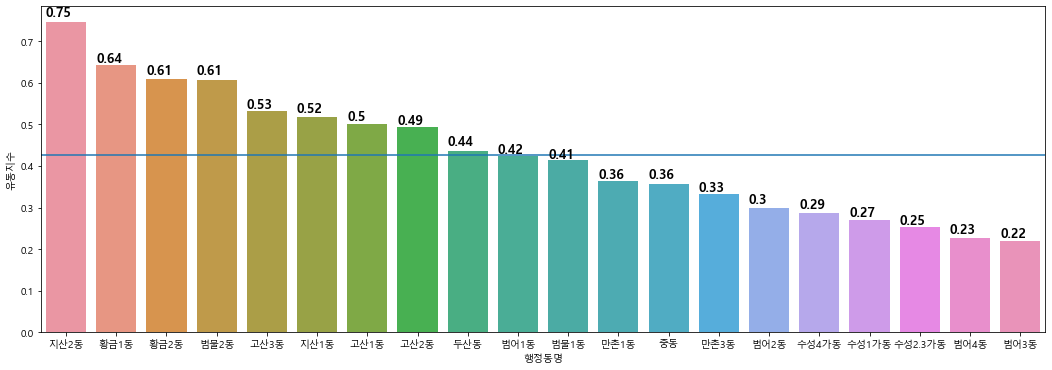

In [118]:
# 대구수성구
suseong_index = sk_index_sep_daegu_suseong.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '유동지수')

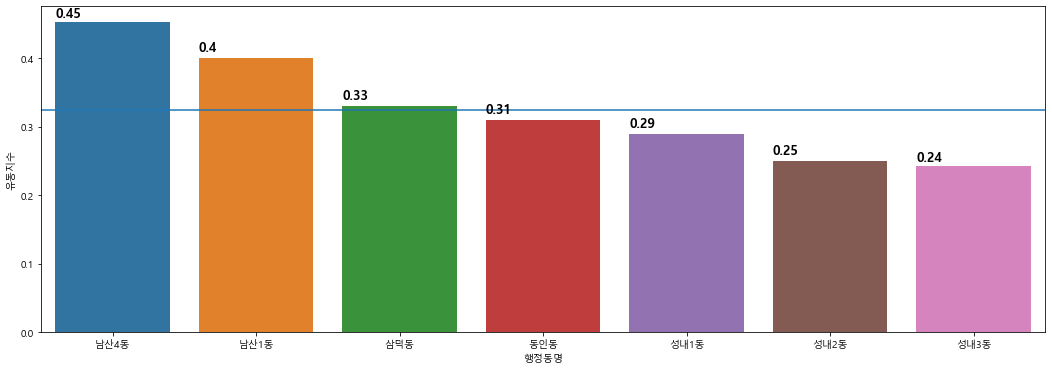

In [119]:
# 대구중구
junggu_index = sk_index_sep_daegu_junggu.pivot_table(index='행정동명', values='유동지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유동지수')

# cj(물류) 데이터 살펴보기

In [120]:
# 지수 생성을 위한 주차별 테이블을 생성
cj_index = get_index_table(cj, "물류건수")
cj_index.columns = ['주차', '시명', '구명', '행정동명', '물류건수_2019', '물류건수_2020']

In [121]:
cj_index['물류평균_2019'] = cj_index['물류건수_2019'].rolling(window=3, min_periods=1).mean()
cj_index['물류평균_2020'] = cj_index['물류건수_2020'].rolling(window=3, min_periods=1).mean()

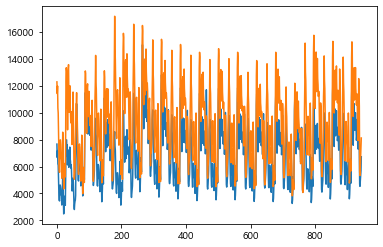

In [122]:
# 물류의 추세는 비슷비슷함
cj_index['물류평균_2019'].plot()
cj_index['물류평균_2020'].plot()

--> 2020년도와 2019년도의 물류의  경향성은 비슷하다고 보여짐

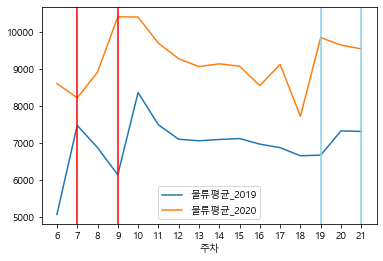

In [123]:
cj_index.groupby('주차')['물류평균_2019'].mean().plot()
cj_index.groupby('주차')['물류평균_2020'].mean().plot()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.xticks(range(6,22))
plt.legend()

plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

### 7-9 주차의 물류는 상승

# 서울/대구 분리

In [124]:
cj_index_seoul = cj_index[cj_index['시명'] == '서울특별시']
cj_index_daegu = cj_index[cj_index['시명'] == '대구광역시']

## 서울의 물류 이평부터 보기

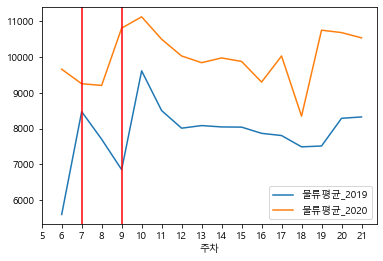

In [125]:
cj_index_seoul.groupby("주차")['물류평균_2019'].mean().plot()
cj_index_seoul.groupby("주차")['물류평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 대구의 물류 이평 보기

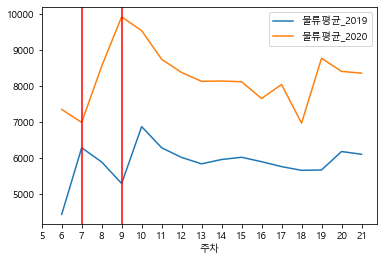

In [126]:
cj_index_daegu.groupby("주차")['물류평균_2019'].mean().plot()
cj_index_daegu.groupby("주차")['물류평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 물류평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 물류지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [143]:
cj_index['물류지수'] = (cj_index['물류평균_2020'] * 100) / cj_index['물류평균_2019']
cj_index['물류지수'] = get_scaled(cj_index, '물류지수')

## 마찬가지로 다른 지표들과 척도를 맞추기위해 스케일링

## 평균적인 유동인구 지수

In [144]:
cj_index

,주차,시명,구명,행정동명,물류건수_2019,물류건수_2020,물류평균_2019,물류평균_2020,물류지수
0,6,대구광역시,수성구,고산1동,7672,12298,7672.000000,12298.000000,0.55
1,6,대구광역시,수성구,고산2동,5677,10554,6674.500000,11426.000000,0.63
2,6,대구광역시,수성구,고산3동,8217,13126,7188.666667,11992.666667,0.60
3,6,대구광역시,수성구,두산동,4704,7369,6199.333333,10349.666667,0.60
4,6,대구광역시,수성구,만촌1동,5371,9451,6097.333333,9982.000000,0.58
...,...,...,...,...,...,...,...,...,...
939,21,서울특별시,중구,중림동,5897,7641,4532.000000,5341.333333,0.26
940,21,서울특별시,중구,청구동,5501,6966,4899.000000,6054.333333,0.30
941,21,서울특별시,중구,필동,4459,5349,5285.666667,6652.000000,0.31
942,21,서울특별시,중구,황학동,7105,9778,5688.333333,7364.333333,0.34


In [145]:
cj_index['물류지수'].mean()

0.36975635593220374

In [148]:
cj_index.groupby("시명")['물류지수'].mean()

시명
대구광역시    0.418171
서울특별시    0.328906
Name: 물류지수, dtype: float64

### 대구의 물류지수가 더 높음!

### 전체말고 보고싶은 7-9 주차의 유동인구만을 봐보자

In [149]:
cj_index_sep = cj_index[cj_index['주차'].isin(range(7,10))]
cj_index_sep_seoul = cj_index_sep[cj_index_sep['시명'] == '서울특별시']
cj_index_sep_daegu = cj_index_sep[cj_index_sep['시명'] == '대구광역시']

In [150]:
cj_index_sep['물류지수'].mean()

0.39412429378531083

In [151]:
# 시별로 살펴보기
cj_index_sep.groupby("시명")['물류지수'].mean()

시명
대구광역시    0.466667
서울특별시    0.332917
Name: 물류지수, dtype: float64

### -> 마찬가지로 7-9주차에 대구의 물류가 더 많이 증가한 모습

## 서울/대구 구별로 살펴보기

In [152]:
cj_index_sep_seoul['물류지수'].mean()

0.33291666666666664

In [153]:
# 서울의 구별
cj_index_sep_seoul.groupby("구명")['물류지수'].mean()

구명
노원구    0.348333
중구     0.313095
Name: 물류지수, dtype: float64

물류지수의 총 량 : 0.33333565076338084 인데 비해

노원구가 0.348832으로 더 높아서 물류를 더 많이시키는 모습이고
중구는 작년도에 비해 오르긴했지만 서울의 평균은 못따라감.

In [154]:
cj_index_sep_daegu['물류지수'].mean()

0.46666666666666673

In [155]:
cj_index_sep_daegu.groupby("구명")['물류지수'].mean()

구명
수성구    0.513500
중구     0.332857
Name: 물류지수, dtype: float64

대구의 경우 유동인구 타격을 덜받았던 수성구가 택배를 훨씬 많이시킴

## 시각화 함수 - 유동지수

In [156]:
def plot_region_dong_flow(df, x_axis, gu_name, line, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['유동지수'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['행정동명'].values
    sns.barplot(x = x_axis, y='유동지수', data=df, order=plot_order)
    plt.axhline(line)
    df = df.sort_values(by="유동지수", ascending=False)
    df['유동지수'] = np.round(df['유동지수'],2)
    for idx, score in enumerate(df['유동지수']):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

## 동별로 살펴보자

In [157]:
# 서울 구별로 나눈 데이터
cj_index_sep_seoul_nowon = cj_index_sep_seoul[cj_index_sep_seoul['구명'] == '노원구']
cj_index_sep_seoul_junggu = cj_index_sep_seoul[cj_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
cj_index_sep_daegu_suseong = cj_index_sep_daegu[cj_index_sep_daegu['구명'] == '수성구']
cj_index_sep_daegu_junggu = cj_index_sep_daegu[cj_index_sep_daegu['구명'] == '중구']

In [158]:
cj_index_sep_seoul_nowon['물류지수'].mean()

0.34833333333333316

##  서울 - 노원구


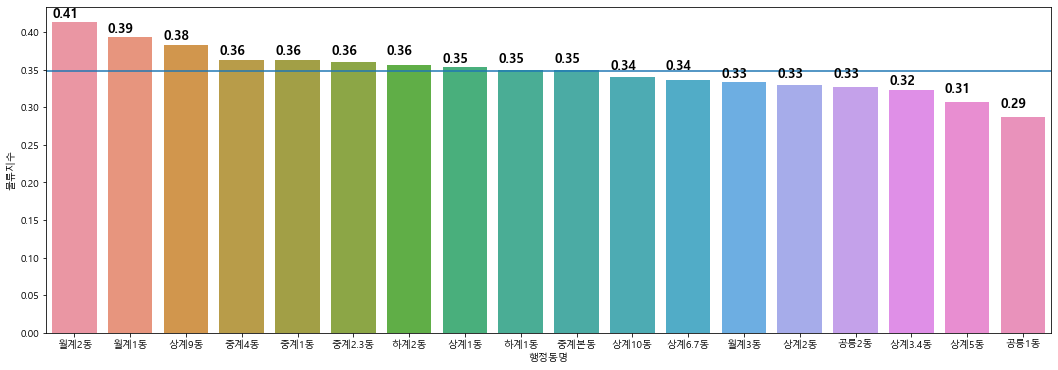

In [160]:
# 서울노원구
nowon_index = cj_index_sep_seoul_nowon.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '물류지수')

## 서울 - 중구

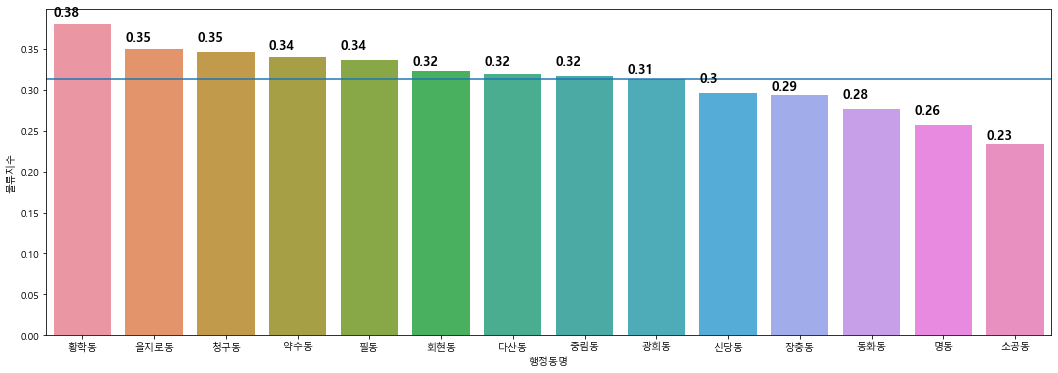

In [161]:
# 서울중구
junggu_index = cj_index_sep_seoul_junggu.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '물류지수')

## 대구 - 수성구

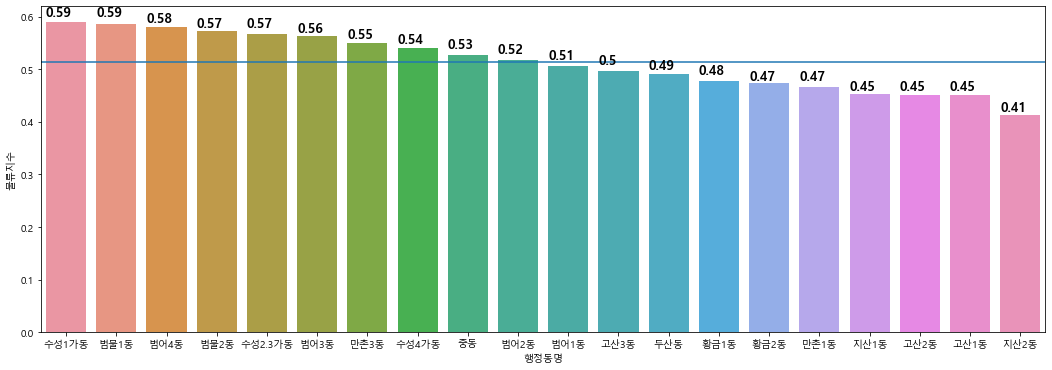

In [163]:
# 대구수성구
suseong_index = cj_index_sep_daegu_suseong.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '중구', '물류지수')

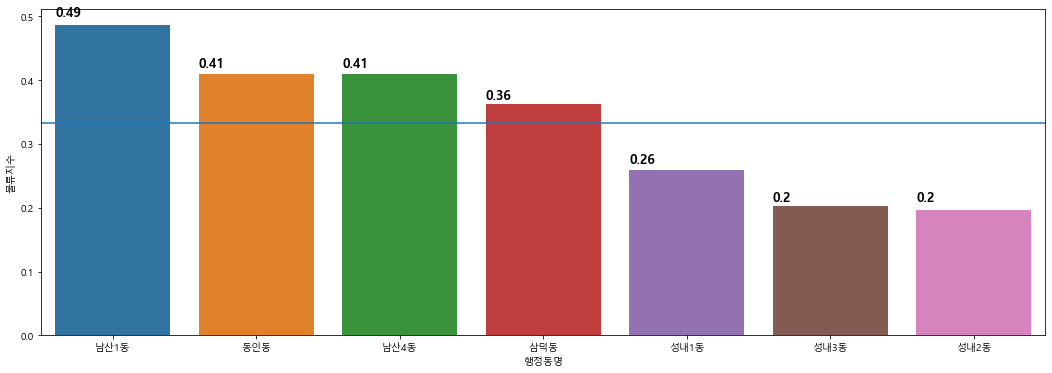

In [162]:
# 대구중구
junggu_index = cj_index_sep_daegu_junggu.pivot_table(index='행정동명', values='물류지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '물류지수')

# gs(유통) 데이터 살펴보기

In [164]:
# 지수 생성을 위한 주차별 테이블을 생성
gs_index = get_index_table(gs, "매출지수")
gs_index.columns = ['주차', '시명', '구명', '행정동명', '매출지수_2019', '매출지수_2020']

In [165]:
gs_index['유통평균_2019'] = gs_index['매출지수_2019'].rolling(window=3, min_periods=1).mean()
gs_index['유통평균_2020'] = gs_index['매출지수_2020'].rolling(window=3, min_periods=1).mean()

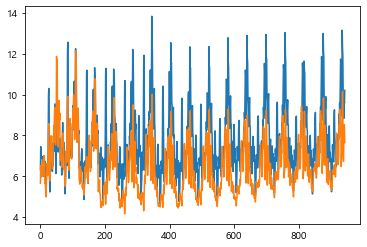

In [166]:
# 물류의 추세는 비슷비슷함
gs_index['유통평균_2019'].plot()
gs_index['유통평균_2020'].plot()

--> 2020년도와 2019년도의 유통의 경향성은 비슷하다고 보여짐

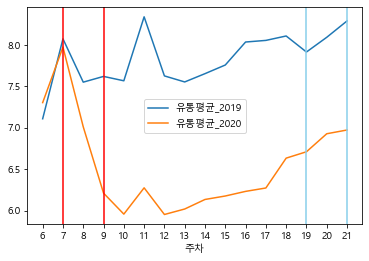

In [167]:
gs_index.groupby('주차')['유통평균_2019'].mean().plot()
gs_index.groupby('주차')['유통평균_2020'].mean().plot()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.xticks(range(6,22))
plt.legend()

plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

### 7-9 주차의 물류는 상승

# 서울/대구 분리

In [168]:
gs_index_seoul = gs_index[cj_index['시명'] == '서울특별시']
gs_index_daegu = gs_index[cj_index['시명'] == '대구광역시']

## 서울의 유통 이평부터 보기

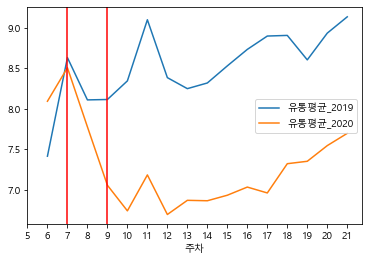

In [169]:
gs_index_seoul.groupby("주차")['유통평균_2019'].mean().plot()
gs_index_seoul.groupby("주차")['유통평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 대구의 유통 이평 보기

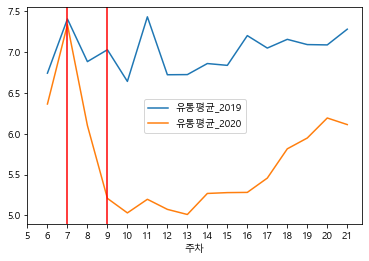

In [170]:
gs_index_daegu.groupby("주차")['유통평균_2019'].mean().plot()
gs_index_daegu.groupby("주차")['유통평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 물류평균 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 물류지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [172]:
gs_index['유통지수'] = (gs_index['유통평균_2020'] * 100) / gs_index['유통평균_2019']
gs_index['유통지수'] = get_scaled(gs_index, '유통지수')

## 평균적인 유동인구 지수

In [173]:
gs_index['유통지수'].mean()

0.4351906779661017

In [174]:
gs_index.groupby("시명")['유통지수'].mean()

시명
대구광역시    0.411389
서울특별시    0.455273
Name: 유통지수, dtype: float64

###  서울의 유통지수가 더 높음!

### 전체말고 보고싶은 7-9 주차의 유통만을 봐보자

In [175]:
gs_index_sep = gs_index[gs_index['주차'].isin(range(7,10))]
gs_index_sep_seoul = gs_index_sep[gs_index_sep['시명'] == '서울특별시']
gs_index_sep_daegu = gs_index_sep[gs_index_sep['시명'] == '대구광역시']

In [176]:
gs_index_sep['유통지수'].mean()

0.49983050847457644

In [177]:
# 시별로 살펴보기
gs_index_sep.groupby("시명")['유통지수'].mean()

시명
대구광역시    0.472222
서울특별시    0.523125
Name: 유통지수, dtype: float64

### -> 마찬가지로 7-9주차에 서울의 유통이 더 증가

## 서울/대구 구별로 살펴보기

In [178]:
gs_index_sep_seoul['유통지수'].mean()

0.5231250000000001

In [179]:
# 서울의 구별
gs_index_sep_seoul.groupby("구명")['유통지수'].mean()

구명
노원구    0.546111
중구     0.493571
Name: 유통지수, dtype: float64

유통지수의 총 량 : 0.5231250000000001 인데 비해

노원구가 0.546111으로 더 높아서 유통을 더 많이 소비하는 모습이고
중구는 서울의 평균은 못따라감.

In [180]:
gs_index_sep_daegu['유통지수'].mean()

0.4722222222222223

In [181]:
gs_index_sep_daegu.groupby("구명")['유통지수'].mean()

구명
수성구    0.492333
중구     0.414762
Name: 유통지수, dtype: float64

대구의 경우 유동인구 타격을 덜받았던 수성구가 유통을 훨씬 더 많이함

## 동별로 살펴보자

In [183]:
# 서울 구별로 나눈 데이터
gs_index_sep_seoul_nowon = gs_index_sep_seoul[gs_index_sep_seoul['구명'] == '노원구']
gs_index_sep_seoul_junggu = gs_index_sep_seoul[gs_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
gs_index_sep_daegu_suseong = gs_index_sep_daegu[gs_index_sep_daegu['구명'] == '수성구']
gs_index_sep_daegu_junggu = gs_index_sep_daegu[gs_index_sep_daegu['구명'] == '중구']

In [184]:
gs_index_sep_seoul_nowon['유통지수'].mean()

0.5461111111111111

##  서울 - 노원구


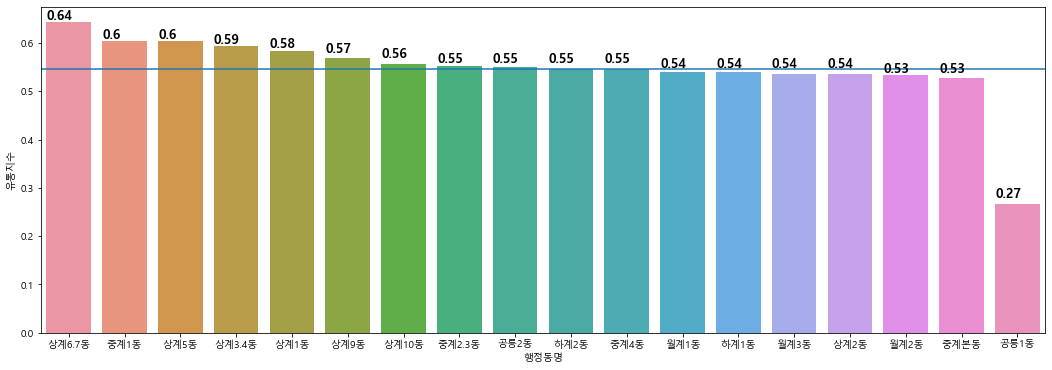

In [188]:
# 서울노원구
nowon_index = gs_index_sep_seoul_nowon.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '유통지수')

## 서울 - 중구

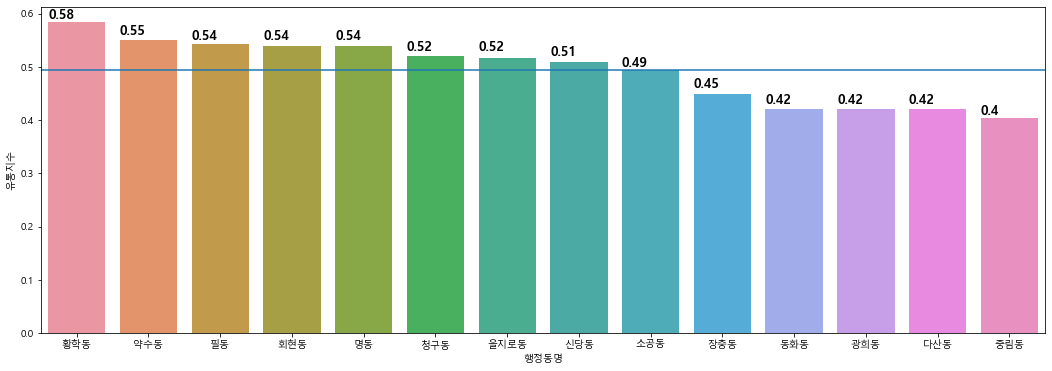

In [187]:
# 서울중구
junggu_index = gs_index_sep_seoul_junggu.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유통지수')

## 대구 - 수성구

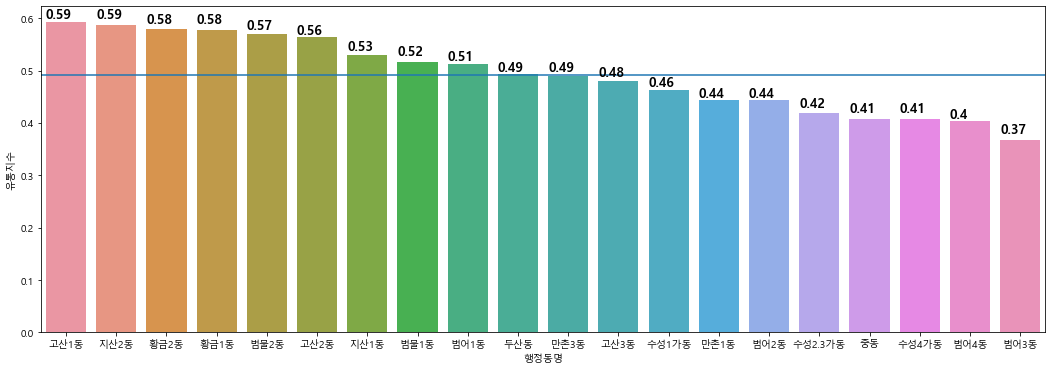

In [186]:
# 대구수성구
suseong_index = gs_index_sep_daegu_suseong.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '유통지수')

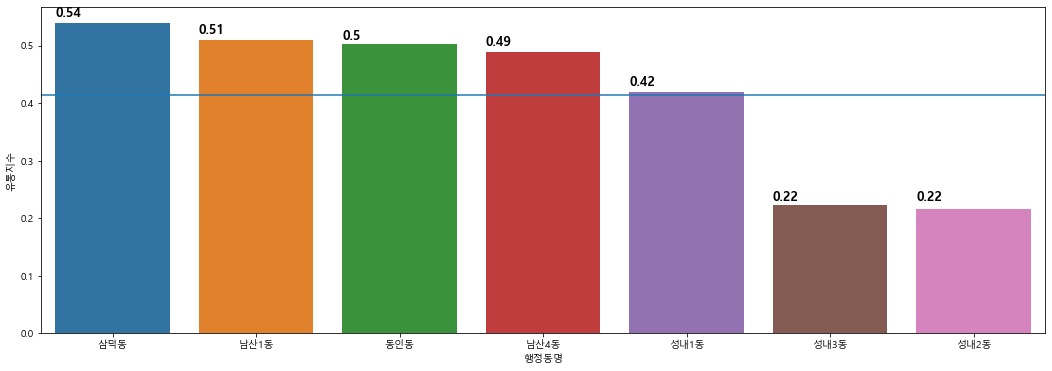

In [185]:
# 대구중구
junggu_index = gs_index_sep_daegu_junggu.pivot_table(index='행정동명', values='유통지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '유통지수')

## -> 유통의 경우 훅훅 떨어지는 친구들이 있었음!

# card(매출) 데이터 살펴보기

In [189]:
card

,일자,이용건수,이용금액,행정동명,업종명,시명,구명,년,월,일,주차
0,2019-02-04,11,352,동인동,숙박,대구광역시,중구,2019,2,4,6
1,2019-02-04,5,30,동인동,숙박,대구광역시,중구,2019,2,4,6
2,2019-02-04,5,30,동인동,숙박,대구광역시,중구,2019,2,4,6
3,2019-02-04,5,108,동인동,레저업소,대구광역시,중구,2019,2,4,6
4,2019-02-04,11,162,동인동,레저업소,대구광역시,중구,2019,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...
2111230,2020-05-24,33,312,상계10동,음료식품,서울특별시,노원구,2020,5,24,21
2111231,2020-05-24,9,106,상계10동,음료식품,서울특별시,노원구,2020,5,24,21
2111232,2020-05-24,5,26,상계10동,음료식품,서울특별시,노원구,2020,5,24,21
2111233,2020-05-24,14,249,상계10동,음료식품,서울특별시,노원구,2020,5,24,21


In [190]:
# 지수 생성을 위한 주차별 테이블을 생성
card_index = get_index_table(card, "이용금액")
card_index.columns = ['주차', '시명', '구명', '행정동명', '이용금액_2019', '이용금액_2020']

In [191]:
card_index['금액평균_2019'] = card_index['이용금액_2019'].rolling(window=3, min_periods=1).mean()
card_index['금액평균_2020'] = card_index['이용금액_2020'].rolling(window=3, min_periods=1).mean()

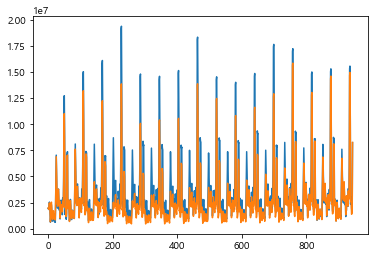

In [192]:
# 물류의 추세는 비슷비슷함
card_index['금액평균_2019'].plot()
card_index['금액평균_2020'].plot()

--> 2020년도와 2019년도의 물류의  경향성은 비슷하다고 보여짐

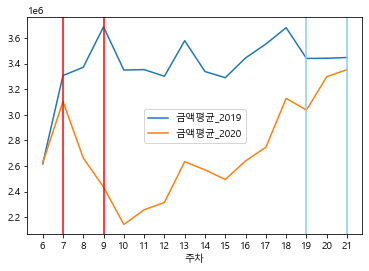

In [193]:
card_index.groupby('주차')['금액평균_2019'].mean().plot()
card_index.groupby('주차')['금액평균_2020'].mean().plot()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

plt.xticks(range(6,22))
plt.legend()

plt.axvline(x=19, color='skyblue')
plt.axvline(x=21, color='skyblue')

### 7-9 주차의 지출은 하락

# 서울/대구 분리

In [194]:
card_index_seoul = card_index[card_index['시명'] == '서울특별시']
card_index_daegu = card_index[card_index['시명'] == '대구광역시']

## 서울의 금액 이평부터 보기

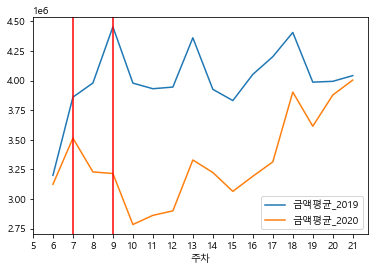

In [195]:
card_index_seoul.groupby("주차")['금액평균_2019'].mean().plot()
card_index_seoul.groupby("주차")['금액평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 대구의 ㄱ금액 이평 보기

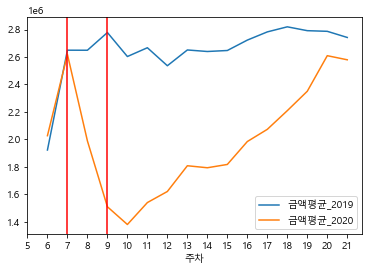

In [196]:
card_index_daegu.groupby("주차")['금액평균_2019'].mean().plot()
card_index_daegu.groupby("주차")['금액평균_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=7, color='red')
plt.axvline(x=9, color='red')

## 지출 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 물류지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [197]:
card_index['지출지수'] = (card_index['금액평균_2020'] * 100) / card_index['금액평균_2019']
card_index['지출지수'] = get_scaled(card_index, '지출지수')

## 평균적인 지출 지수

In [198]:
card_index['지출지수'].mean()

0.4413877118644072

In [199]:
card_index.groupby("시명")['지출지수'].mean()

시명
대구광역시    0.414537
서울특별시    0.464043
Name: 지출지수, dtype: float64

### 서울의 지출지수가 더높음!

### 전체말고 보고싶은 7-9 주차의 지출만을 봐보자

In [200]:
card_index_sep = card_index[card_index['주차'].isin(range(7,10))]
card_index_sep_seoul = card_index_sep[card_index_sep['시명'] == '서울특별시']
card_index_sep_daegu = card_index_sep[card_index_sep['시명'] == '대구광역시']

In [201]:
card_index_sep['지출지수'].mean()

0.4415819209039551

In [202]:
# 시별로 살펴보기
card_index_sep.groupby("시명")['지출지수'].mean()

시명
대구광역시    0.422963
서울특별시    0.457292
Name: 지출지수, dtype: float64

### -> 마찬가지로 7-9주차에 대구의 카드 매출이 더 낮음

## 서울/대구 구별로 살펴보기

In [203]:
card_index_sep_seoul['지출지수'].mean()

0.4572916666666668

In [204]:
# 서울의 구별
card_index_sep_seoul.groupby("구명")['지출지수'].mean()

구명
노원구    0.491481
중구     0.413333
Name: 지출지수, dtype: float64

지출지수의 총 량 : 0.4572916666666668 인데 비해

노원구가 0.491481으로 더 높아서 지출은 더 많이하고
중구는 작년도에 타격을 엄청 봄

In [205]:
card_index_sep_daegu['지출지수'].mean()

0.4229629629629629

In [206]:
card_index_sep_daegu.groupby("구명")['지출지수'].mean()

구명
수성구    0.439000
중구     0.377143
Name: 지출지수, dtype: float64

대구의 경우 유동인구 타격을 덜받았던 수성구가 매출이 높음

## 동별로 살펴보자

In [207]:
# 서울 구별로 나눈 데이터
card_index_sep_seoul_nowon = card_index_sep_seoul[card_index_sep_seoul['구명'] == '노원구']
card_index_sep_seoul_junggu = card_index_sep_seoul[card_index_sep_seoul['구명'] == '중구']

# 대구 구별로 나눈 데이터
card_index_sep_daegu_suseong = card_index_sep_daegu[card_index_sep_daegu['구명'] == '수성구']
card_index_sep_daegu_junggu = card_index_sep_daegu[card_index_sep_daegu['구명'] == '중구']

In [208]:
card_index_sep_seoul_nowon['지출지수'].mean()

0.4914814814814814

##  서울 - 노원구


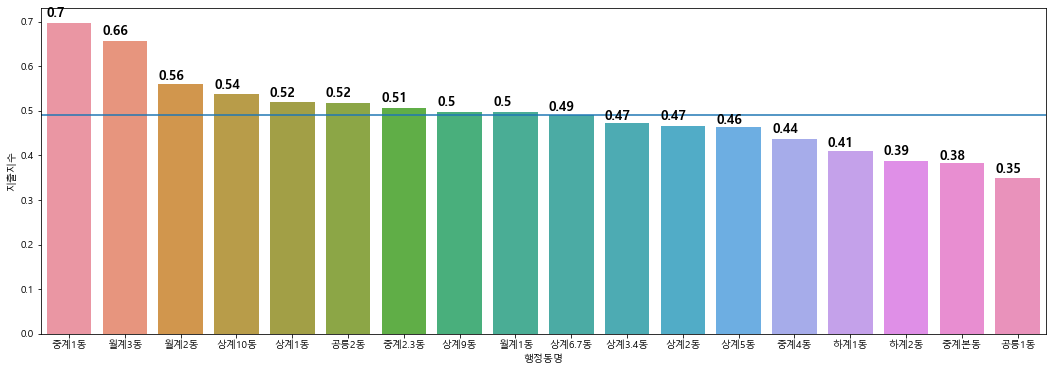

In [212]:
# 서울노원구
nowon_index = card_index_sep_seoul_nowon.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
nowon_index.reset_index(inplace=True)
get_plot_trend(nowon_index, '행정동명', '노원구', '지출지수')

## 서울 - 중구

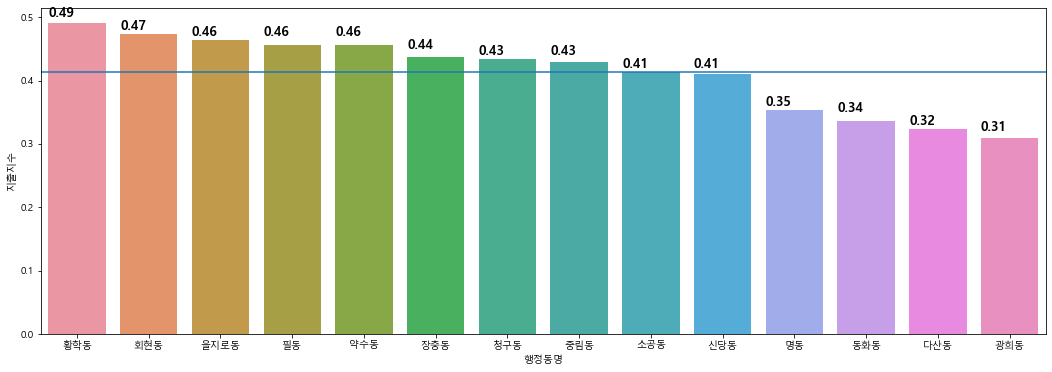

In [211]:
# 서울중구
junggu_index = card_index_sep_seoul_junggu.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '지출지수')

## 대구 - 수성구

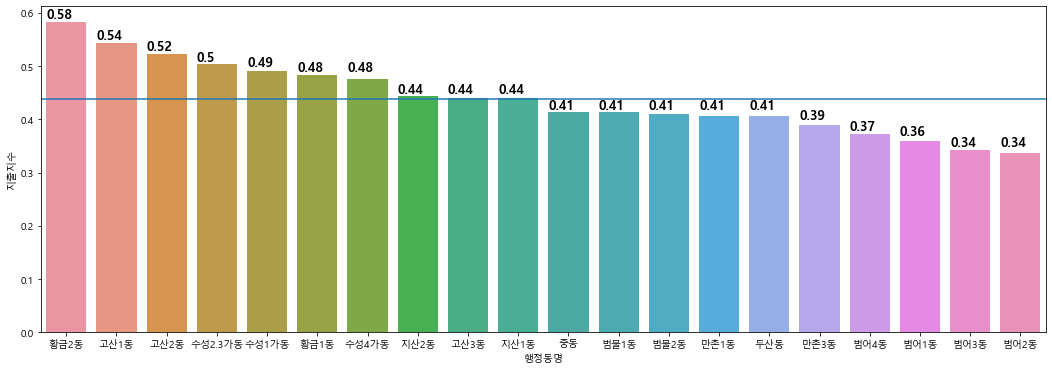

In [210]:
# 대구수성구
suseong_index = card_index_sep_daegu_suseong.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
suseong_index.reset_index(inplace=True)
get_plot_trend(suseong_index, '행정동명', '수성구', '지출지수')

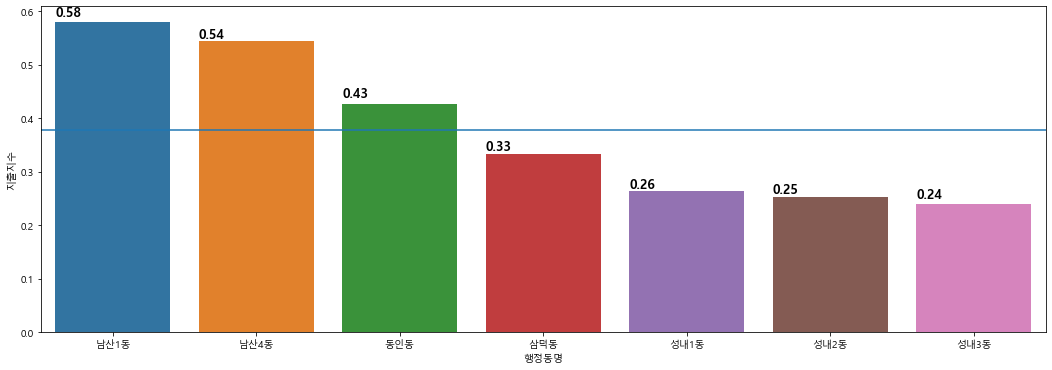

In [209]:
# 대구중구
junggu_index = card_index_sep_daegu_junggu.pivot_table(index='행정동명', values='지출지수', aggfunc='mean')
junggu_index.reset_index(inplace=True)
get_plot_trend(junggu_index, '행정동명', '중구', '지출지수')

## -> 이제 유동지수, 물류지수, 유통지수, 지출지수를 바탕으로 집단을 나누고자 함

In [213]:
index_group_cj = cj_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='물류지수', aggfunc='mean').reset_index()
index_group_sk = sk_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='유동지수', aggfunc='mean').reset_index()
index_group_gs = gs_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='유통지수', aggfunc='mean').reset_index()
index_group_card = card_index_sep.pivot_table(index=['시명','구명', '행정동명'], values='지출지수', aggfunc='mean').reset_index()

index_group = index_group_sk.merge(index_group_cj, how='inner', on=['시명','구명','행정동명'])
index_group = index_group.merge(index_group_gs, how='inner', on =['시명','구명','행정동명'])
index_group = index_group.merge(index_group_card, how='inner', on =['시명','구명','행정동명'])

# 지수 group table 생성
index_group

,시명,구명,행정동명,유동지수,물류지수,유통지수,지출지수
0,대구광역시,수성구,고산1동,0.500000,0.450000,0.593333,0.543333
1,대구광역시,수성구,고산2동,0.493333,0.450000,0.563333,0.523333
2,대구광역시,수성구,고산3동,0.533333,0.496667,0.480000,0.440000
3,대구광역시,수성구,두산동,0.436667,0.490000,0.493333,0.406667
4,대구광역시,수성구,만촌1동,0.363333,0.466667,0.443333,0.406667
5,대구광역시,수성구,만촌3동,0.333333,0.550000,0.490000,0.390000
6,대구광역시,수성구,범물1동,0.413333,0.586667,0.516667,0.413333
7,대구광역시,수성구,범물2동,0.606667,0.573333,0.570000,0.410000
8,대구광역시,수성구,범어1동,0.423333,0.506667,0.513333,0.360000
9,대구광역시,수성구,범어2동,0.300000,0.516667,0.443333,0.336667


In [215]:
index_group['유동지수'] = get_scaled(index_group, '유동지수')
index_group['물류지수'] = get_scaled(index_group, '물류지수')
index_group['유통지수'] = get_scaled(index_group, '유통지수')
index_group['지출지수'] = get_scaled(index_group, '지출지수')

In [1369]:
# 데이터 표준화 진행
from sklearn.preprocessing import MinMaxScaler

cols = ['물류지수', '유동지수', '유통지수', '지출지수']
# cols = ['물류지수', '유동지수']
# cols = ['물류지수', '유통지수']

scaler = MinMaxScaler()
index_group[cols] = scaler.fit_transform(index_group[cols])

In [217]:
data = index_group.set_index(['시명', '구명', '행정동명'])

In [218]:
# PCA를 이용해 데이터의 분산을 잘 설명해줄 수 있는 주성분 2개를 찾음
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=1122)
data_pca = pca.fit_transform(data)

data = pd.DataFrame(data_pca, columns = ['pc1', 'pc2'])
print(f"분산 설명 :{pca.explained_variance_ratio_}")

분산 설명 :[0.48722566 0.32732199]


### 데이터 변동의 약 80%를 설명해주는 모습

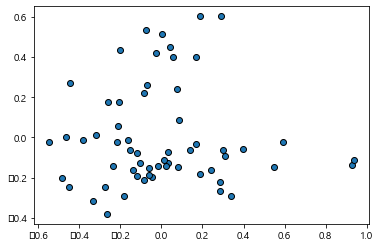

In [219]:
plt.scatter(data['pc1'], data['pc2'], linewidth=1, edgecolor='black')

plt.show()

In [220]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_n = 1
best_score = -1

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, random_state=1015)
    kmeans.fit(data)
    cluster = kmeans.predict(data)
    score = silhouette_score(data, cluster)
    
    print('클러스터의 수 : {}, 실루엣 점수 : {:.3f}'.format(n_cluster, score))
    if score > best_score :
        best_n = n_cluster
        best_score = score
        
print('가장 높은 실루엣 점수를 가진 클러스터 수 : {}, 실루엣 점수 : {:.3f}'.format(best_n, best_score))

클러스터의 수 : 2, 실루엣 점수 : 0.361
클러스터의 수 : 3, 실루엣 점수 : 0.471
클러스터의 수 : 4, 실루엣 점수 : 0.419
클러스터의 수 : 5, 실루엣 점수 : 0.422
클러스터의 수 : 6, 실루엣 점수 : 0.429
클러스터의 수 : 7, 실루엣 점수 : 0.405
클러스터의 수 : 8, 실루엣 점수 : 0.337
클러스터의 수 : 9, 실루엣 점수 : 0.365
클러스터의 수 : 10, 실루엣 점수 : 0.384
가장 높은 실루엣 점수를 가진 클러스터 수 : 3, 실루엣 점수 : 0.471


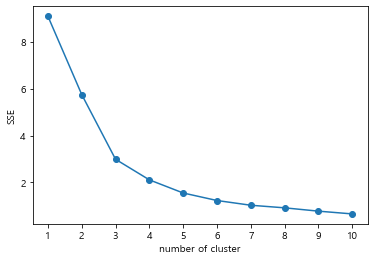

In [221]:
# elbow 기법
def elbow(x):
    k = []
    sse = []
    
    for i in range(1, 11):
        model = KMeans(n_clusters = i, random_state=1015)
        model.fit(x)
        sse.append(model.inertia_)
        k.append(i)
        
    plt.plot(k, sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.xticks(range(1,11))
    plt.show() 

elbow(data)

In [222]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1015)

kmeans.fit(data)

cluster = kmeans.predict(data)

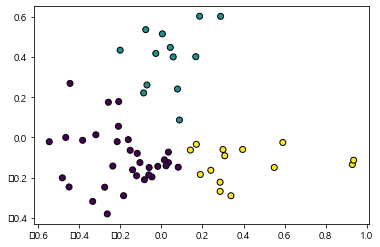

In [223]:
plt.scatter(data['pc1'], data['pc2'], c=cluster, linewidth=1, edgecolor='black')

plt.show()

In [224]:
# pca를 통해 나눈 군집을 원래 데이터에 추가
index_group['그룹'] = cluster

In [225]:
index_group.groupby('그룹').count()

,시명,구명,행정동명,유동지수,물류지수,유통지수,지출지수
그룹,,,,,,,
0,32,32,32,32,32,32,32
1,13,13,13,13,13,13,13
2,14,14,14,14,14,14,14


In [226]:
df = index_group.groupby("그룹")['물류지수', '유통지수', '유동지수', '지출지수'].mean()

In [227]:
# 나뉜 집단간의 상관계수 
df.corr()

,물류지수,유통지수,유동지수,지출지수
물류지수,1.000000,0.146412,-0.073667,0.342097
유통지수,0.146412,1.000000,0.975750,0.979626
유동지수,-0.073667,0.975750,1.000000,0.911910
지출지수,0.342097,0.979626,0.911910,1.000000


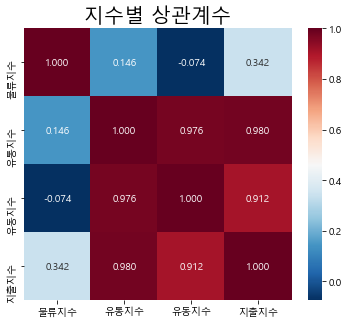

In [228]:
fig, ax = plt.subplots( figsize = (6, 5))
plt.title('지수별 상관계수', fontsize=20)
sns.heatmap(df.corr(), cmap='RdBu_r', annot = True, fmt='.3f')

### -> 유통, 유동, 카드지수가 강한 양의 상관관계를 갖고있음.

#### 이를 바탕으로 유동인구가 유통의 매출지수와 카드매출에 강한 연관성을 갖고있음을 알 수 있다.

#### out 지표 : 유동인구, 유통, 카드매출
#### in 지표 : 물류

In [229]:
# out지표와 in 지표를 만들어내 그룹의 특성 분류
df['out_index'] = df[['유통지수', '유동지수', '지출지수']].mean(axis=1)
df['in_index'] = df['물류지수']

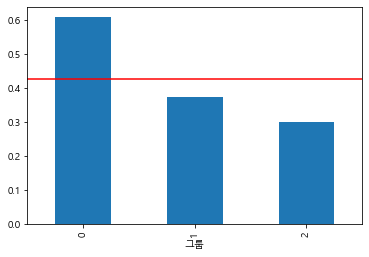

In [230]:
df['out_index'].plot(kind='bar')
plt.axhline(df['out_index'].mean(), color='red')

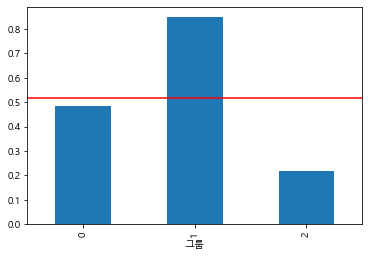

In [231]:
df['in_index'].plot(kind='bar')
plt.axhline(df['in_index'].mean(), color='red')

## 정리 

## 0번 군집의 성향 : out지표가 높다 -> 사람들이 많이 돌아다니는 지역(드라이브 스루)
## 1번 군집의 성향 : in 지표가 높다 -> 물류를 많이 시키는 지역(구독경제)
## 2번 군집의 성향 : out, in 지표가 모두 낮은 지역(해석 필요)

In [235]:
# 시/구/동 별 그룹을 담고있는 테이블
group_dic = {
    0 : 'out',
    1 : 'in',
    2 : 'abnormal'
}
cluster_table = index_group[['시명', '구명','행정동명', '그룹']]
cluster_table['그룹'] = cluster_table['그룹'].map(group_dic)

# 이제 카드매출의 19~21주차 보자!

In [236]:
def get_line_index_table(df, col_name = ""):
    df_index = df.pivot_table(index=['주차', '시명', '구명', '행정동명', '년', '업종명'], values=[col_name], aggfunc='sum')
    
    df_index_2019 = df_index.xs(2019,level=4, axis=0).reset_index()
    df_index_2020 = df_index.xs(2020,level=4, axis=0).reset_index()
    
    df_index = df_index_2019.merge(df_index_2020, how='inner', on = ['주차', '시명', '구명', '행정동명','업종명'])
    
    return df_index

In [262]:
def get_plot_by_line(df, index=""):
    plt.figure(figsize=(18, 6))
    
    top_down_index = df[index].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['업종명'].values
    sns.barplot(x = '업종명', y=index, data=df, order = plot_order)  
    plt.axhline(df[index].mean())
    df = df.sort_values(by=index, ascending=False)
#     df[index] = np.round(df[index],5)
#     for idx, score in enumerate(df[index]):
#         plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

In [274]:
def get_plot_by_total_line(df, index=""):
    tmp_df = pd.DataFrame()
    fig = plt.figure(figsize=(21, 30))
    lines = df['업종명'].unique()
    
    for idx, line in enumerate(lines):
        tmp_df = df[df['업종명'] == line]    
        sns.barplot(x ='업종명', y=index, hue='그룹', data = tmp_df)
        plt.legend()
#         plt.yticks([0, 50, 100, 150, 200, 250])
        plt.subplot(6,4,idx+1)

In [263]:
card_index_line = get_line_index_table(card, '이용금액')
card_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '이용금액_2019', '이용금액_2020']

card_index_line_sep = card_index_line[card_index_line['주차'].isin(range(19,22))]

card_index_line_sep = card_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

card_index_line_sep

,주차,시명,구명,행정동명,업종명,이용금액_2019,이용금액_2020,그룹
0,19,대구광역시,수성구,고산1동,광학제품,519,7424,out
1,19,대구광역시,수성구,고산1동,레저업소,62573,61123,out
2,19,대구광역시,수성구,고산1동,레저용품,65614,53227,out
3,19,대구광역시,수성구,고산1동,문화취미,12399,10420,out
4,19,대구광역시,수성구,고산1동,보건위생,120393,70517,out
...,...,...,...,...,...,...,...,...
3089,21,서울특별시,중구,회현동,의복,516160,706545,out
3090,21,서울특별시,중구,회현동,자동차정비,91963,91635,out
3091,21,서울특별시,중구,회현동,자동차판매,349,2017,out
3092,21,서울특별시,중구,회현동,주방용구,78570,171710,out


In [264]:
# 카드소비지수 생성
# 2019년의 동주차 이용 금액을 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 판매가 변화했는지 지수로 산출
card_index_line_sep['카드소비지수'] = (card_index_line_sep['이용금액_2020']  * 100) / card_index_line_sep['이용금액_2019']
card_index_line_sep['카드소비지수'] = get_scaled(card_index_line_sep, '카드소비지수')

## 19-21주차의 전반적인 경향

In [265]:
df = card_index_line_sep.pivot_table(index='업종명', values='카드소비지수', aggfunc='mean').reset_index()

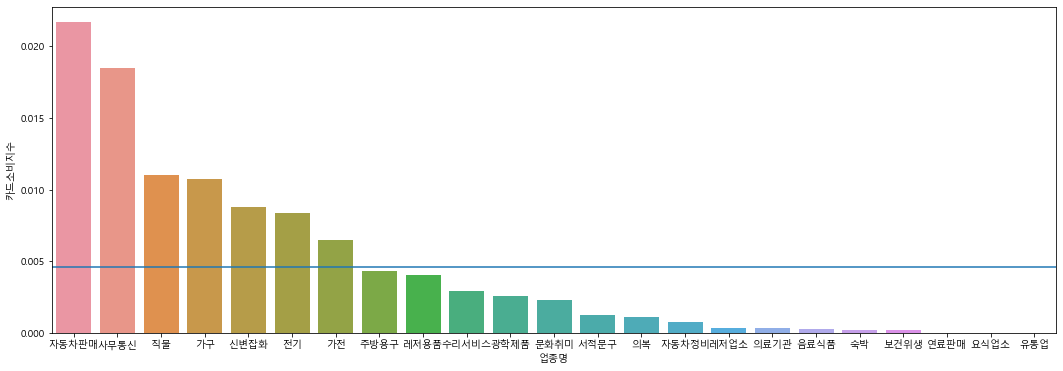

In [266]:
get_plot_by_line(df, "카드소비지수")

# 나눈 지역별로 보기

# 1. out(밖으로 나가는애들 - 드라이브 스루)

In [267]:
df_cluster = card_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '카드소비지수', aggfunc='mean').reset_index()

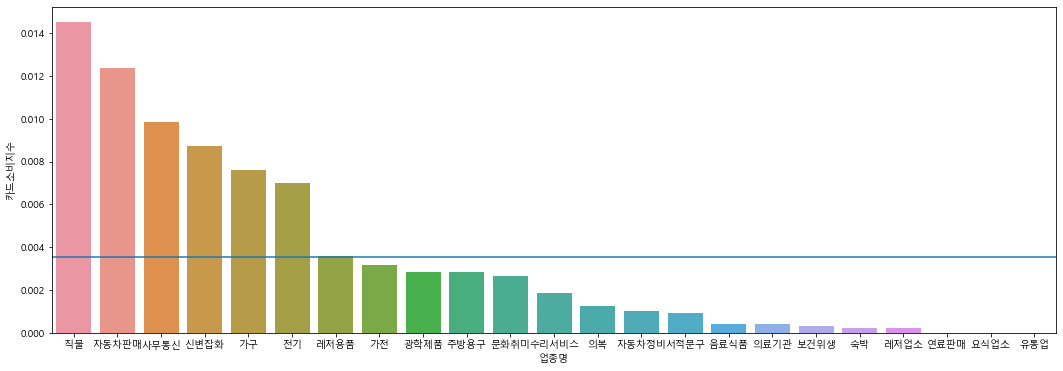

In [268]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '카드소비지수')

# 2. in(물류 많이시킴 -> 구독경제)

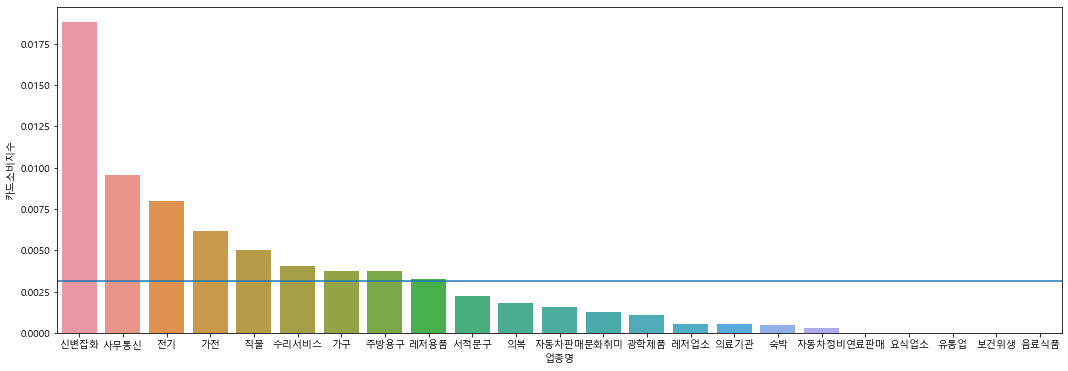

In [271]:
df_cluster_in = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_in.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_in, '카드소비지수')

# 3. abnormal(이상한애들)

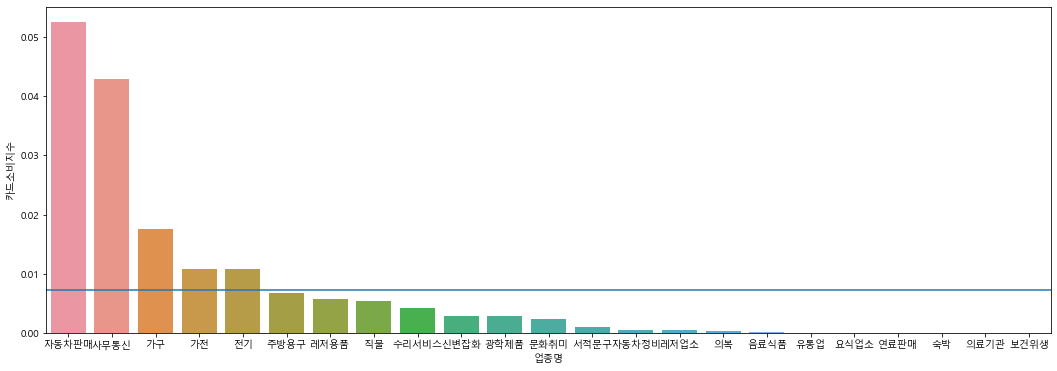

In [272]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '카드소비지수')

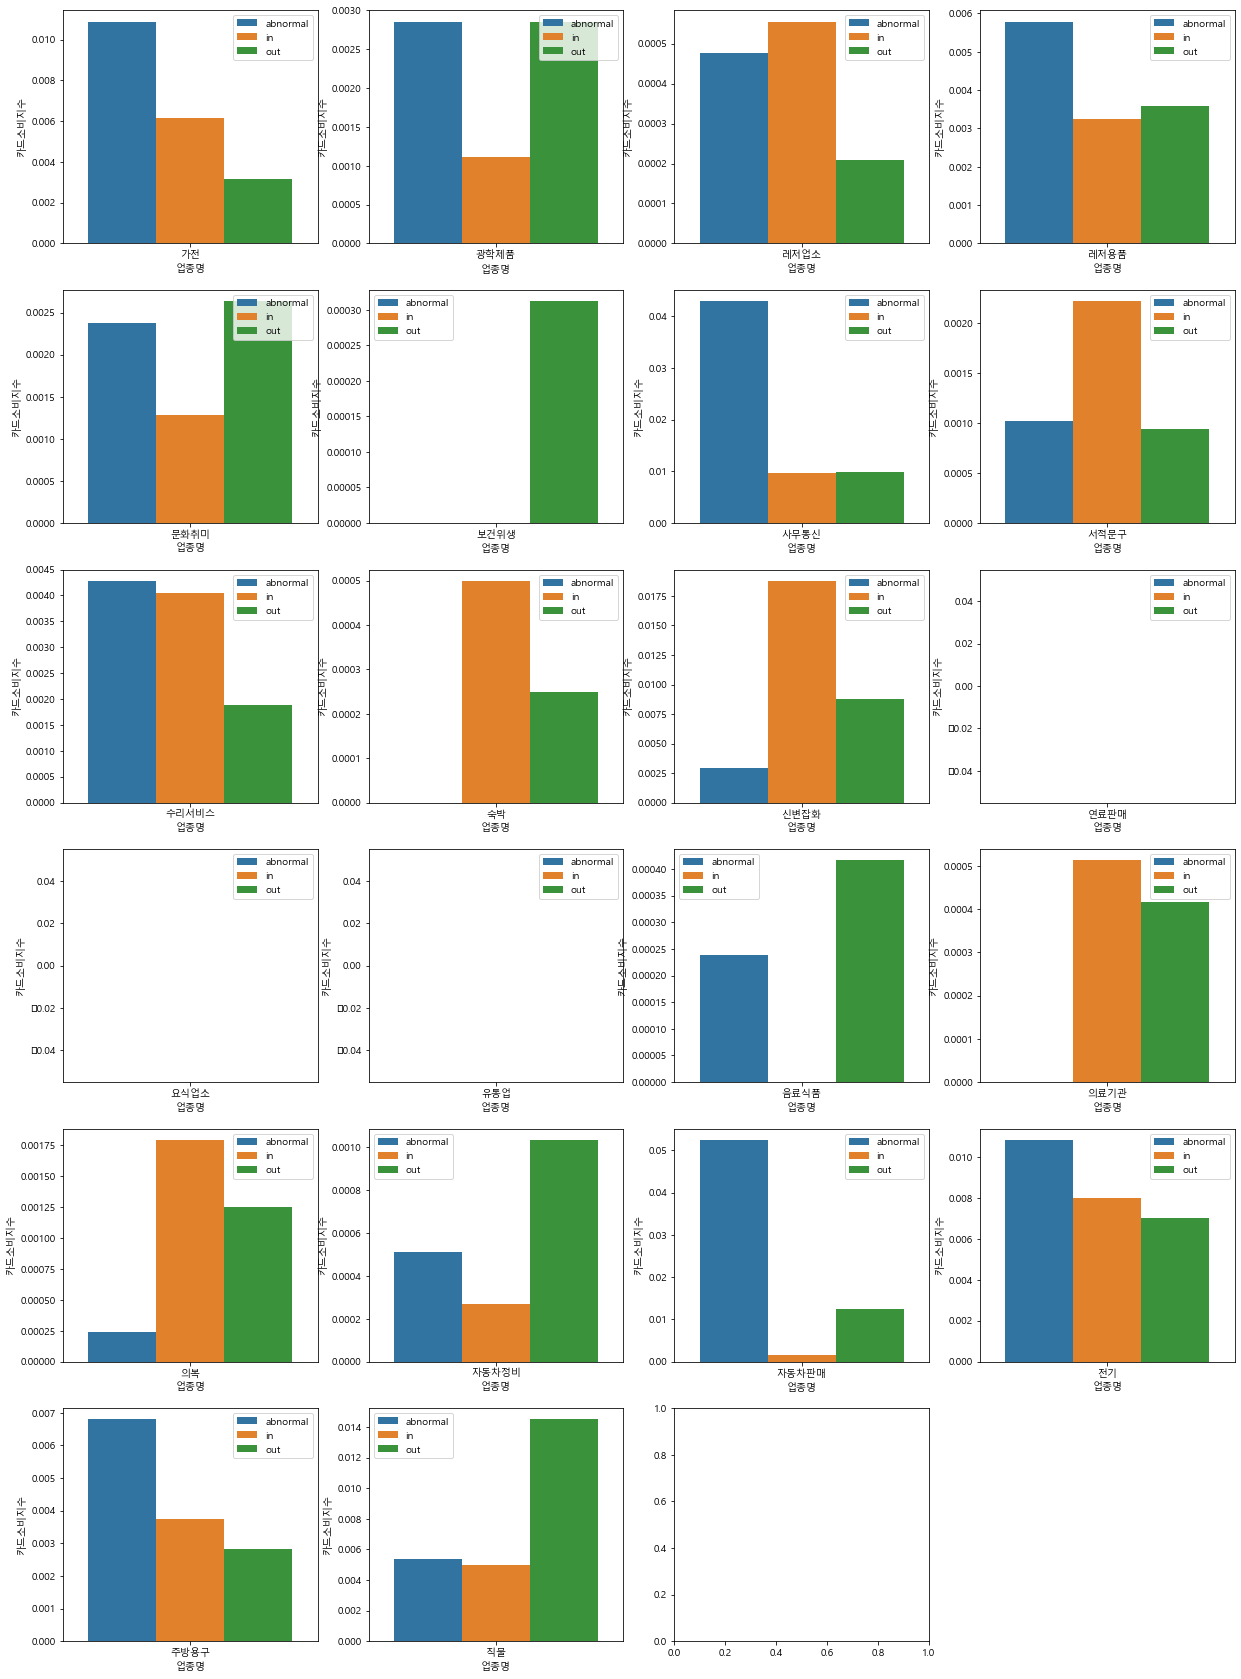

In [275]:
get_plot_by_total_line(df_cluster, '카드소비지수')

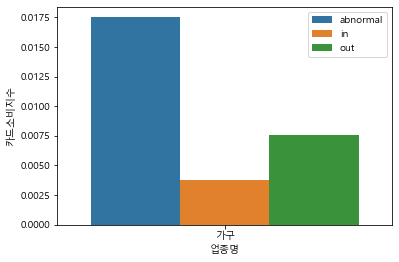

In [277]:
tmp_df = df_cluster[df_cluster['업종명'] == "가구"]    
sns.barplot(x ='업종명', y='카드소비지수', hue='그룹', data = tmp_df)
plt.legend()
# plt.yticks([0, 50, 100, 150, 200, 250])

# 물류 송장 건수

In [278]:
cj_index_line = get_line_index_table(cj, '물류건수')
cj_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '물류건수_2019', '물류건수_2020']

cj_index_line_sep = cj_index_line[cj_index_line['주차'].isin(range(19,22))]

cj_index_line_sep = cj_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

cj_index_line_sep

,주차,시명,구명,행정동명,업종명,물류건수_2019,물류건수_2020,그룹
0,19,대구광역시,수성구,고산1동,가구/인테리어,262,579,out
1,19,대구광역시,수성구,고산1동,도서/음반,733,1160,out
2,19,대구광역시,수성구,고산1동,디지털/가전,567,1137,out
3,19,대구광역시,수성구,고산1동,생활건강,1424,2946,out
4,19,대구광역시,수성구,고산1동,스포츠/레저,120,192,out
...,...,...,...,...,...,...,...,...
1765,21,서울특별시,중구,회현동,식품,1959,2270,out
1766,21,서울특별시,중구,회현동,출산/육아,21,17,out
1767,21,서울특별시,중구,회현동,패션의류,1331,1159,out
1768,21,서울특별시,중구,회현동,패션잡화,848,812,out


In [279]:
# 물류소비지수 생성
# 2019년의 동주차 이용 건수을 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 판매가 변화했는지 지수로 산출
cj_index_line_sep['물류소비지수'] = (cj_index_line_sep['물류건수_2020']  * 100) / cj_index_line_sep['물류건수_2019']
cj_index_line_sep['물류소비지수'] = get_scaled(cj_index_line_sep, '물류소비지수')

## 19-21주차의 전반적인 경향

In [280]:
df = cj_index_line_sep.pivot_table(index='업종명', values='물류소비지수', aggfunc='mean').reset_index()

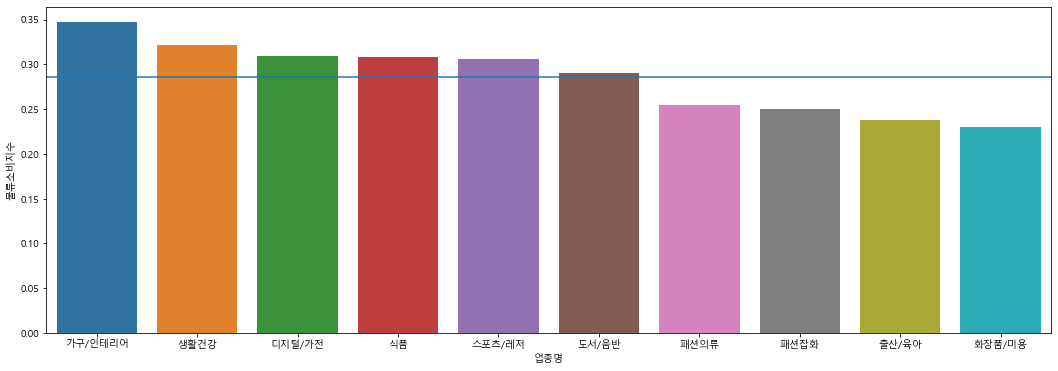

In [281]:
get_plot_by_line(df, '물류소비지수')

# 나눈 지역별로 보기

# 1. out(밖으로 나가는애들 - 드라이브 스루)

In [282]:
df_cluster = cj_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '물류소비지수', aggfunc='mean').reset_index()

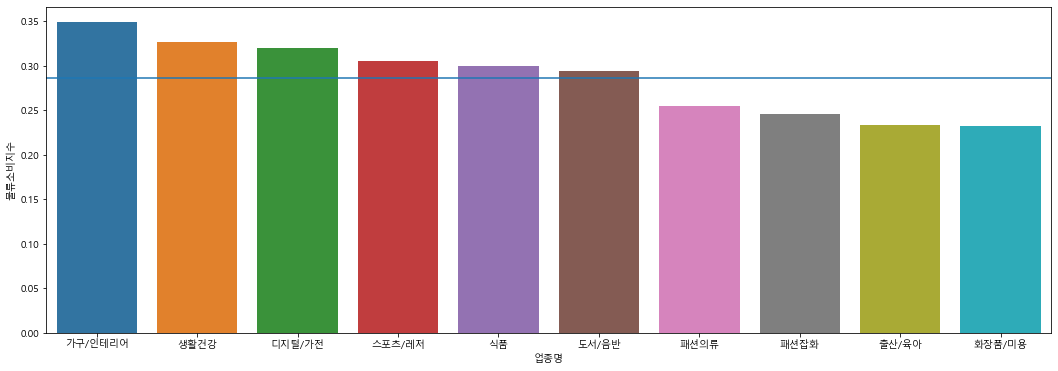

In [283]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '물류소비지수')

# 2. in(물류 많이시킴 -> 구독경제)

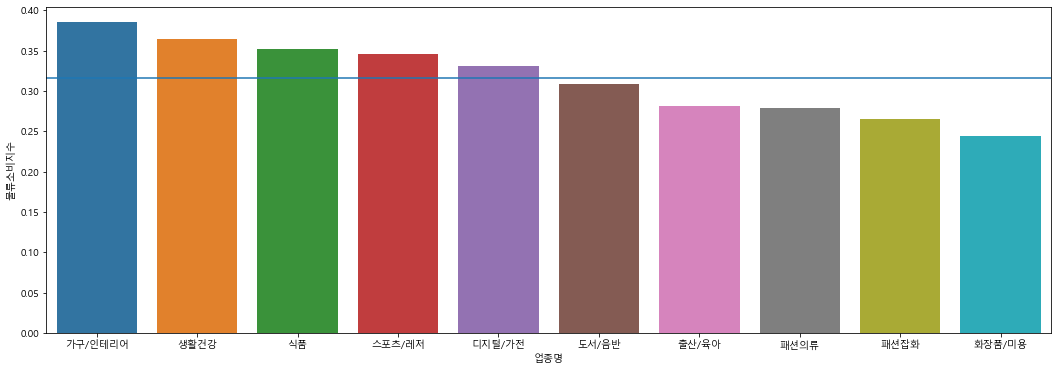

In [285]:
df_cluster_in = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_in.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_in, '물류소비지수')

# 3. abnormal (이상한애들)

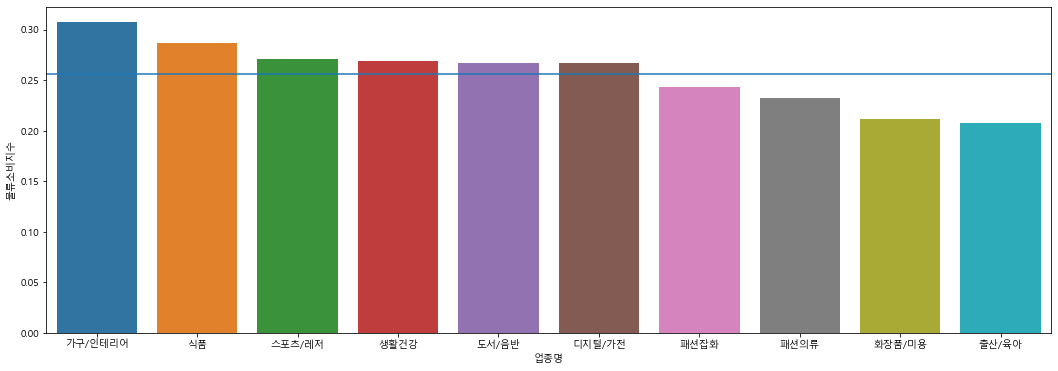

In [284]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '물류소비지수')

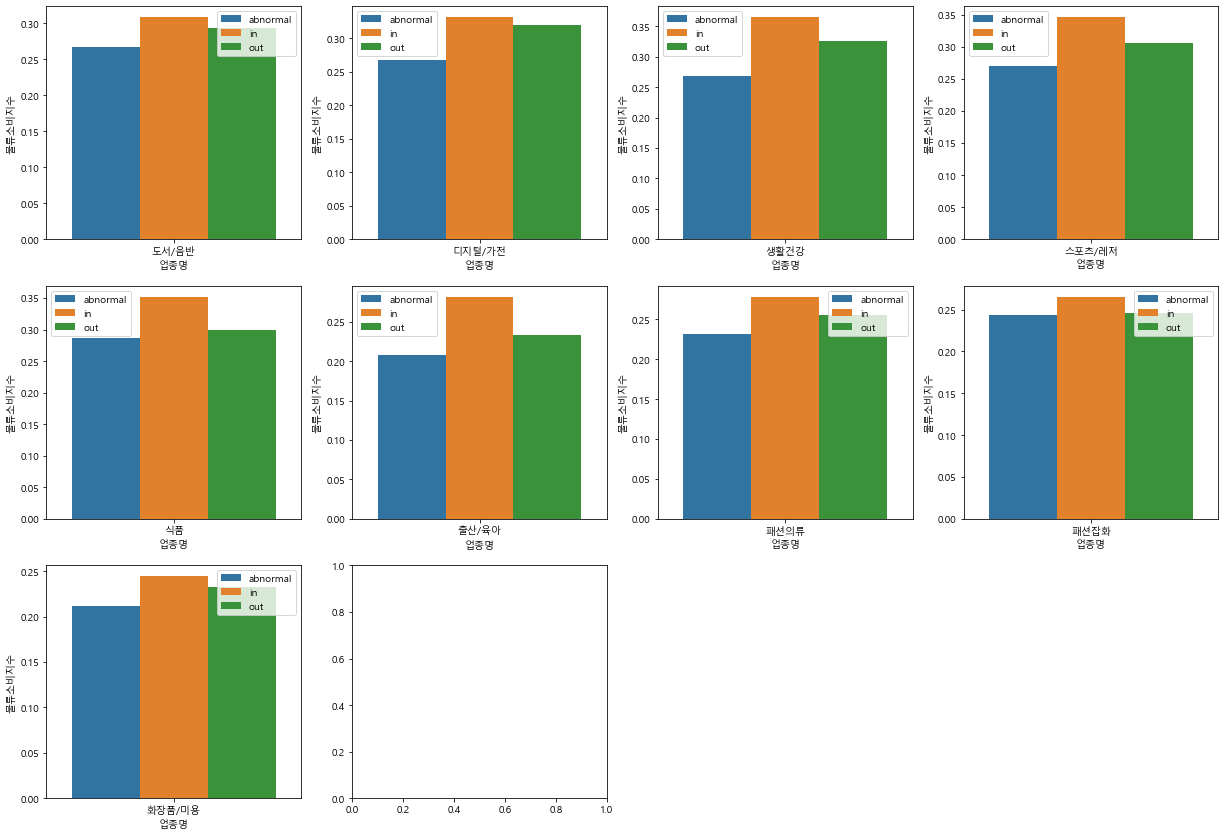

In [287]:
get_plot_by_total_line(df_cluster, '물류소비지수')

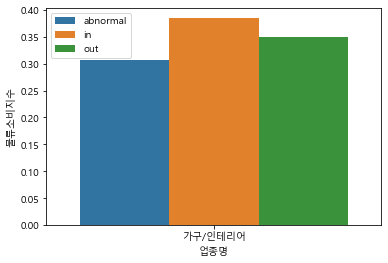

In [288]:
tmp_df = df_cluster[df_cluster['업종명'] == "가구/인테리어"]    
sns.barplot(x ='업종명', y='물류소비지수', hue='그룹', data = tmp_df)
plt.legend()
# plt.yticks([0, 50, 100, 150, 200, 250])

# 유통데이터 보기!!!

In [289]:
# gs 데이터 재조구조화
gs_melt = pd.melt(gs, id_vars=['일자','시명','구명', '행정동명','주차','년'], value_vars=['식사_비중', '간식_비중', '마실거리_비중', '홈&리빙_비중',
       '헬스&뷰티_비중', '취미&여가활동_비중', '사회활동_비중', '임신/육아_비중'], var_name=['업종명'], value_name='유통지수')

gs_index_line = get_line_index_table(gs_melt, '유통지수')
gs_index_line.columns = ['주차', '시명', '구명', '행정동명', '업종명', '유통지수_2019', '유통지수_2020']

gs_index_line_sep = gs_index_line[gs_index_line['주차'].isin(range(19,22))]

gs_index_line_sep = gs_index_line_sep.merge(cluster_table, how='inner', on=['시명','구명','행정동명'])

gs_index_line_sep

,주차,시명,구명,행정동명,업종명,유통지수_2019,유통지수_2020,그룹
0,19,대구광역시,수성구,고산1동,간식_비중,1.346711,1.385509,out
1,19,대구광역시,수성구,고산1동,마실거리_비중,2.895254,2.757717,out
2,19,대구광역시,수성구,고산1동,사회활동_비중,0.035717,0.048464,out
3,19,대구광역시,수성구,고산1동,식사_비중,1.953787,1.839588,out
4,19,대구광역시,수성구,고산1동,임신/육아_비중,0.035650,0.026816,out
...,...,...,...,...,...,...,...,...
1411,21,서울특별시,중구,회현동,식사_비중,1.918850,2.041332,out
1412,21,서울특별시,중구,회현동,임신/육아_비중,0.020066,0.025276,out
1413,21,서울특별시,중구,회현동,취미&여가활동_비중,0.019544,0.019562,out
1414,21,서울특별시,중구,회현동,헬스&뷰티_비중,0.410422,0.681340,out


In [290]:
# 유통소비지수 생성
# 2019년의 동주차 유통 지수를 100으로 보고 2020년의 지수 산출
# -> 2019년도에 비해 얼마나 유통지수가 변했는지 지수로 산출
gs_index_line_sep['유통소비지수'] = (gs_index_line_sep['유통지수_2020']  * 100) / gs_index_line_sep['유통지수_2019']
gs_index_line_sep['유통소비지수'] = get_scaled(gs_index_line_sep, '유통소비지수')

## 19-21주차의 전반적인 경향

In [291]:
df = gs_index_line_sep.pivot_table(index='업종명', values='유통소비지수', aggfunc='mean').reset_index()

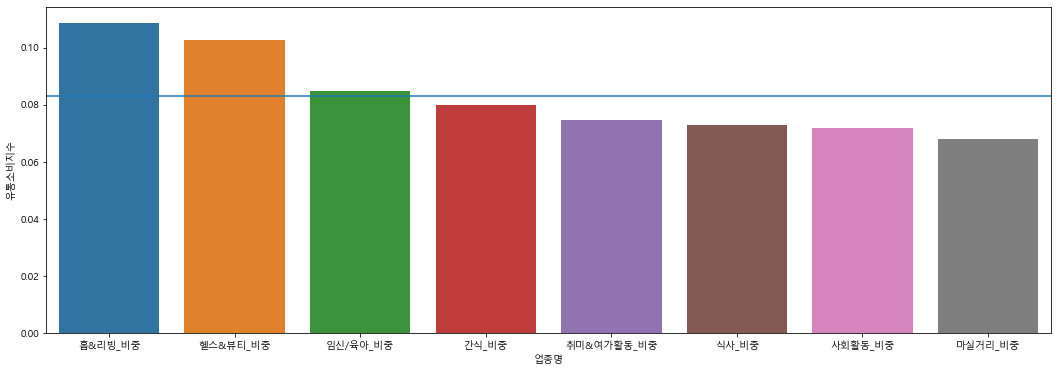

In [292]:
get_plot_by_line(df, '유통소비지수')

# 나눈 지역별로 보기

# 1. out(밖으로 나가는애들 - 드라이브 스루)

In [293]:
df_cluster = gs_index_line_sep.pivot_table(index=['업종명', '그룹'] ,values = '유통소비지수', aggfunc='mean').reset_index()

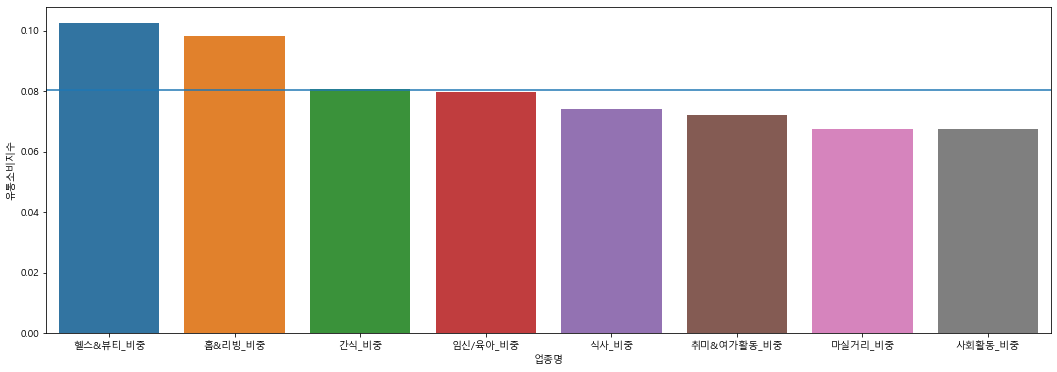

In [294]:
df_cluster_out = df_cluster[df_cluster['그룹'] == 'out']
df_cluster_out.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_out, '유통소비지수')

# 2. in(물류 많이시킴 -> 구독경제)

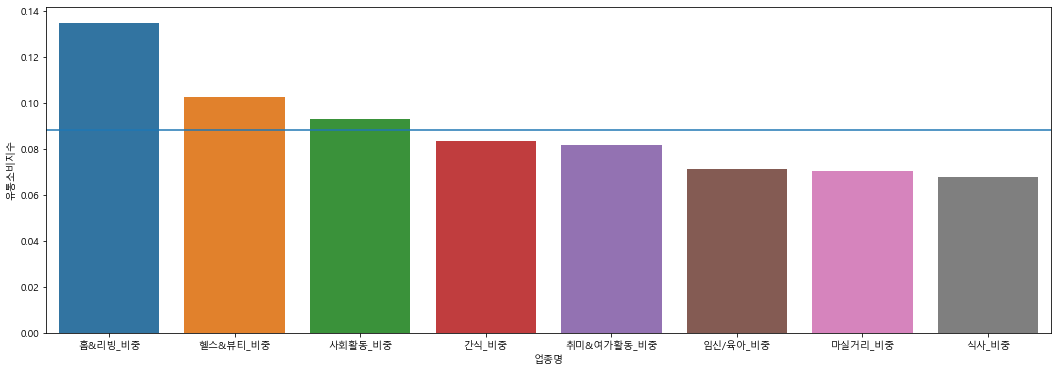

In [295]:
df_cluster_in = df_cluster[df_cluster['그룹'] == 'in']
df_cluster_in.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_in, '유통소비지수')

# 3. abnormal (이상한애들)

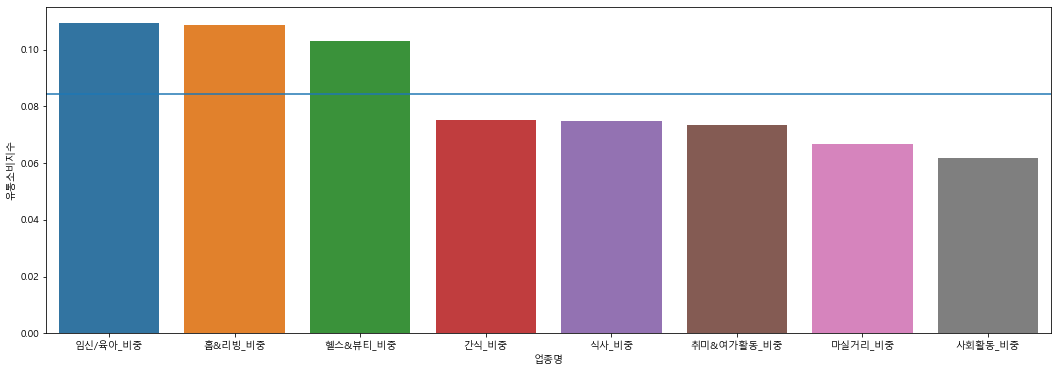

In [296]:
df_cluster_abnormal = df_cluster[df_cluster['그룹'] == 'abnormal']
df_cluster_abnormal.reset_index(drop=True, inplace=True)
get_plot_by_line(df_cluster_abnormal, '유통소비지수')

# 다같이 보기

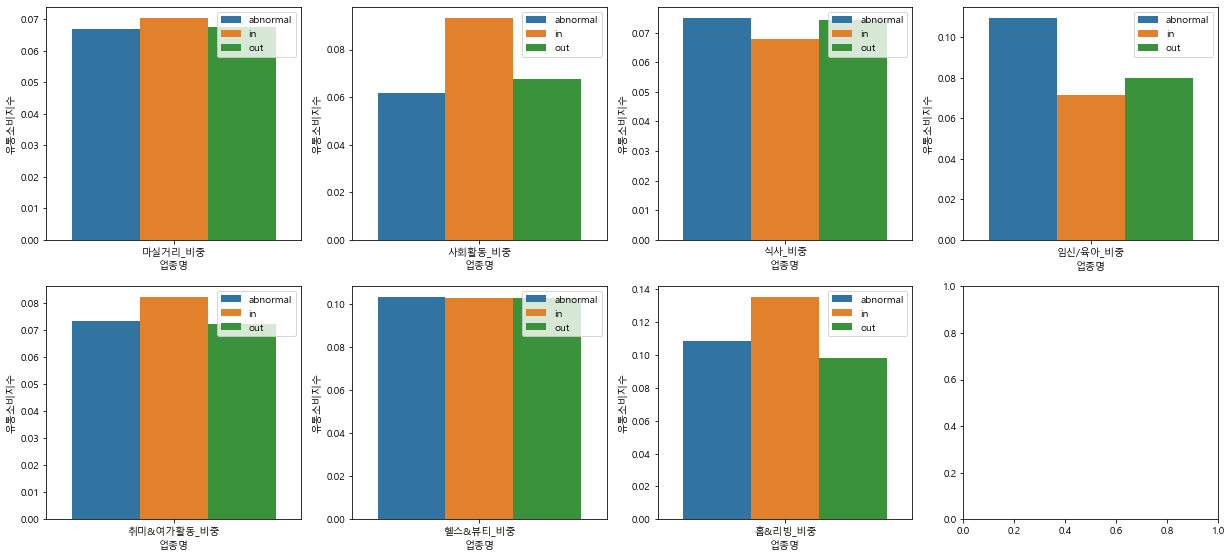

In [297]:
get_plot_by_total_line(df_cluster, '유통소비지수')

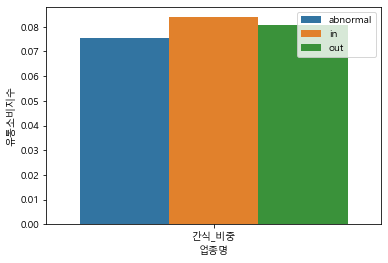

In [298]:
tmp_df = df_cluster[df_cluster['업종명'] == "간식_비중"]    
sns.barplot(x ='업종명', y='유통소비지수', hue='그룹', data = tmp_df)
plt.legend()
# plt.yticks([0, 50, 100, 150, 200, 250])